# **Subsurface Porosity & Permeability Prediction Using ML**

In this project, I'm predicting porosity and permeability of rock formations using well log data and machine learning models.

## Part 1

In this part, we will import the data files and try to find the outliers. It will also have the visualisation of the log data.

In [1]:
! pip install lasio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 1.1 MB/s eta 0:00:00


In [2]:
import lasio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def load_LAS(filename):
    '''
    Load LAS file
    Args:
        filename: LAS file to load
    Return:
        las_df: LAS file in dataframe format
    '''

    #load the data
    las = lasio.read(filename)

    #convert to dataframe
    las_df = las.df()
    las_df = las_df.replace(-999.25, np.nan)

    #create a new column called 'DEPTH'
    las_df['DEPTH']=las_df.index
    return las_df


las_df_well_1 = load_LAS("/content/drive/MyDrive/well_1.las")
las_df_well_1

CALI    DTC  GR  LLD  LLS  MSFL    NPHI    PEF  POTA  RHOB     SGR  \
DEPTH                                                                           
1400.0988   NaN  78.75 NaN  NaN  NaN   NaN     NaN    NaN   NaN   NaN     NaN   
1400.2512   NaN  77.75 NaN  NaN  NaN   NaN     NaN    NaN   NaN   NaN     NaN   
1400.4036   NaN  76.25 NaN  NaN  NaN   NaN     NaN    NaN   NaN   NaN     NaN   
1400.5560   NaN  75.38 NaN  NaN  NaN   NaN     NaN    NaN   NaN   NaN     NaN   
1400.7084   NaN  72.00 NaN  NaN  NaN   NaN     NaN    NaN   NaN   NaN     NaN   
...         ...    ...  ..  ...  ...   ...     ...    ...   ...   ...     ...   
1757.7816   NaN  77.81 NaN  NaN  NaN   NaN  0.2385  2.621   2.4  2.66  135.75   
1757.9340   NaN  77.81 NaN  NaN  NaN   NaN  0.2385  2.621   2.4  2.66  135.75   
1758.0864   NaN  77.81 NaN  NaN  NaN   NaN  0.2385  2.621   2.4  2.66  135.75   
1758.2388   NaN    NaN NaN  NaN  NaN   NaN  0.2385  2.621   2.4  2.66  135.75   
1758.3912   NaN    NaN NaN  NaN  NaN   NaN     NaN    NaN   NaN  2.66     NaN   

             THOR  URAN   AZIMUTH     INC      EASTING    NORTHING        TVD  \
DEPTH                                                                           
1400.0988     NaN   NaN  156.6060  1.6745  400943.1563  87039.0547  1399.7334   
1400.2512     NaN   NaN  156.6067  1.6753  400943.1563  87039.0469  1399.8857   
1400.4036     NaN   NaN  156.6074  1.6760  400943.1563  87039.0469  1400.0381   
1400.5560     NaN   NaN  156.6080  1.6768  400943.1563  87039.0391  1400.1904   
1400.7084     NaN   NaN  156.6087  1.6775  400943.1563  87039.0391  1400.3428   
...           ...   ...       ...     ...          ...         ...        ...   
1757.7816  17.563  3.85  148.0049  0.2704  400946.0625  87032.6563  1757.3054   
1757.9340  17.563  3.85  148.0049  0.2704  400946.0625  87032.6563  1757.4578   
1758.0864  17.563  3.85  148.0049  0.2704  400946.0625  87032.6563  1757.6101   
1758.2388  17.563  3.85  148.0049  0.2704  400946.0625  87032.6563  1757.7626   
1758.3912     NaN   NaN  148.0049  0.2704  400946.0625  87032.6563  1757.9149   

               DEPTH  
DEPTH                 
1400.0988  1400.0988  
1400.2512  1400.2512  
1400.4036  1400.4036  
1400.5560  1400.5560  
1400.7084  1400.7084  
...              ...  
1757.7816  1757.7816  
1757.9340  1757.9340  
1758.0864  1758.0864  
1758.2388  1758.2388  
1758.3912  1758.3912  

[2352 rows x 19 columns]

In [5]:
#Drop the records containing null values

las_df_well_1 = las_df_well_1.dropna()
las_df_well_1

CALI    DTC        GR     LLD     LLS    MSFL    NPHI     PEF  \
DEPTH                                                                         
1487.7288  12.4378  76.81  119.3730  5.0465  4.6057  4.2766  0.3733  3.3767   
1487.8812  12.4228  76.69  118.9050  4.7519  4.4229  3.6847  0.3619  3.3475   
1488.0336  12.4752  78.75  115.5210  4.4015  4.1144  4.8480  0.3636  3.2653   
1488.1860  12.3841  79.88  113.4710  4.2874  4.0418  4.7533  0.3513  3.2798   
1488.3384  12.3665  81.06  119.3750  4.0245  3.8622  3.3685  0.3460  3.3632   
...            ...    ...       ...     ...     ...     ...     ...     ...   
1740.8652   8.5168  83.00  106.5310  3.5122  3.4866  4.2308  0.2812  3.5513   
1741.0176   8.5268  82.00  106.8210  3.5838  3.5709  4.2920  0.2799  3.5422   
1741.1700   8.2754  81.00  103.8810  3.5194  3.5287  2.8878  0.2624  3.4832   
1741.3224   8.1771  79.00  109.0080  3.6690  3.6544  1.5963  0.2517  3.4974   
1741.4748   8.4039  78.00   95.9824  3.9553  3.9360  2.4552  0.2462  3.4774   

             POTA  RHOB      SGR     THOR    URAN   AZIMUTH     INC  \
DEPTH                                                                 
1487.7288  3.4000  2.53  125.869  10.3179  4.1150  159.9219  2.2297   
1487.8812  3.4000  2.54  128.924  10.5556  4.2309  159.9514  2.2370   
1488.0336  3.4045  2.54  126.191  10.2088  4.1058  159.9810  2.2444   
1488.1860  3.7958  2.53  133.917  10.2958  4.2836  160.0106  2.2518   
1488.3384  3.8998  2.53  136.002  10.2981  4.3744  160.0401  2.2592   
...           ...   ...      ...      ...     ...       ...     ...   
1740.8652  3.0000  2.61  132.765  14.3849  3.8187  148.0049  0.2704   
1741.0176  3.0000  2.61  133.229  14.4892  3.7822  148.0049  0.2704   
1741.1700  3.0031  2.60  132.471  14.4279  3.6991  148.0049  0.2704   
1741.3224  3.1954  2.61  137.562  14.7191  3.8674  148.0049  0.2704   
1741.4748  3.1000  2.61  130.882  14.0740  3.5628  148.0049  0.2704   

               EASTING    NORTHING        TVD      DEPTH  
DEPTH                                                     
1487.7288  400944.1875  87036.5000  1487.3195  1487.7288  
1487.8812  400944.1875  87036.4922  1487.4718  1487.8812  
1488.0336  400944.1875  87036.4922  1487.6240  1488.0336  
1488.1860  400944.1875  87036.4844  1487.7764  1488.1860  
1488.3384  400944.1875  87036.4766  1487.9286  1488.3384  
...                ...         ...        ...        ...  
1740.8652  400946.0313  87032.7266  1740.3892  1740.8652  
1741.0176  400946.0313  87032.7266  1740.5415  1741.0176  
1741.1700  400946.0313  87032.7266  1740.6940  1741.1700  
1741.3224  400946.0313  87032.7266  1740.8463  1741.3224  
1741.4748  400946.0313  87032.7266  1740.9988  1741.4748  

[1666 rows x 19 columns]

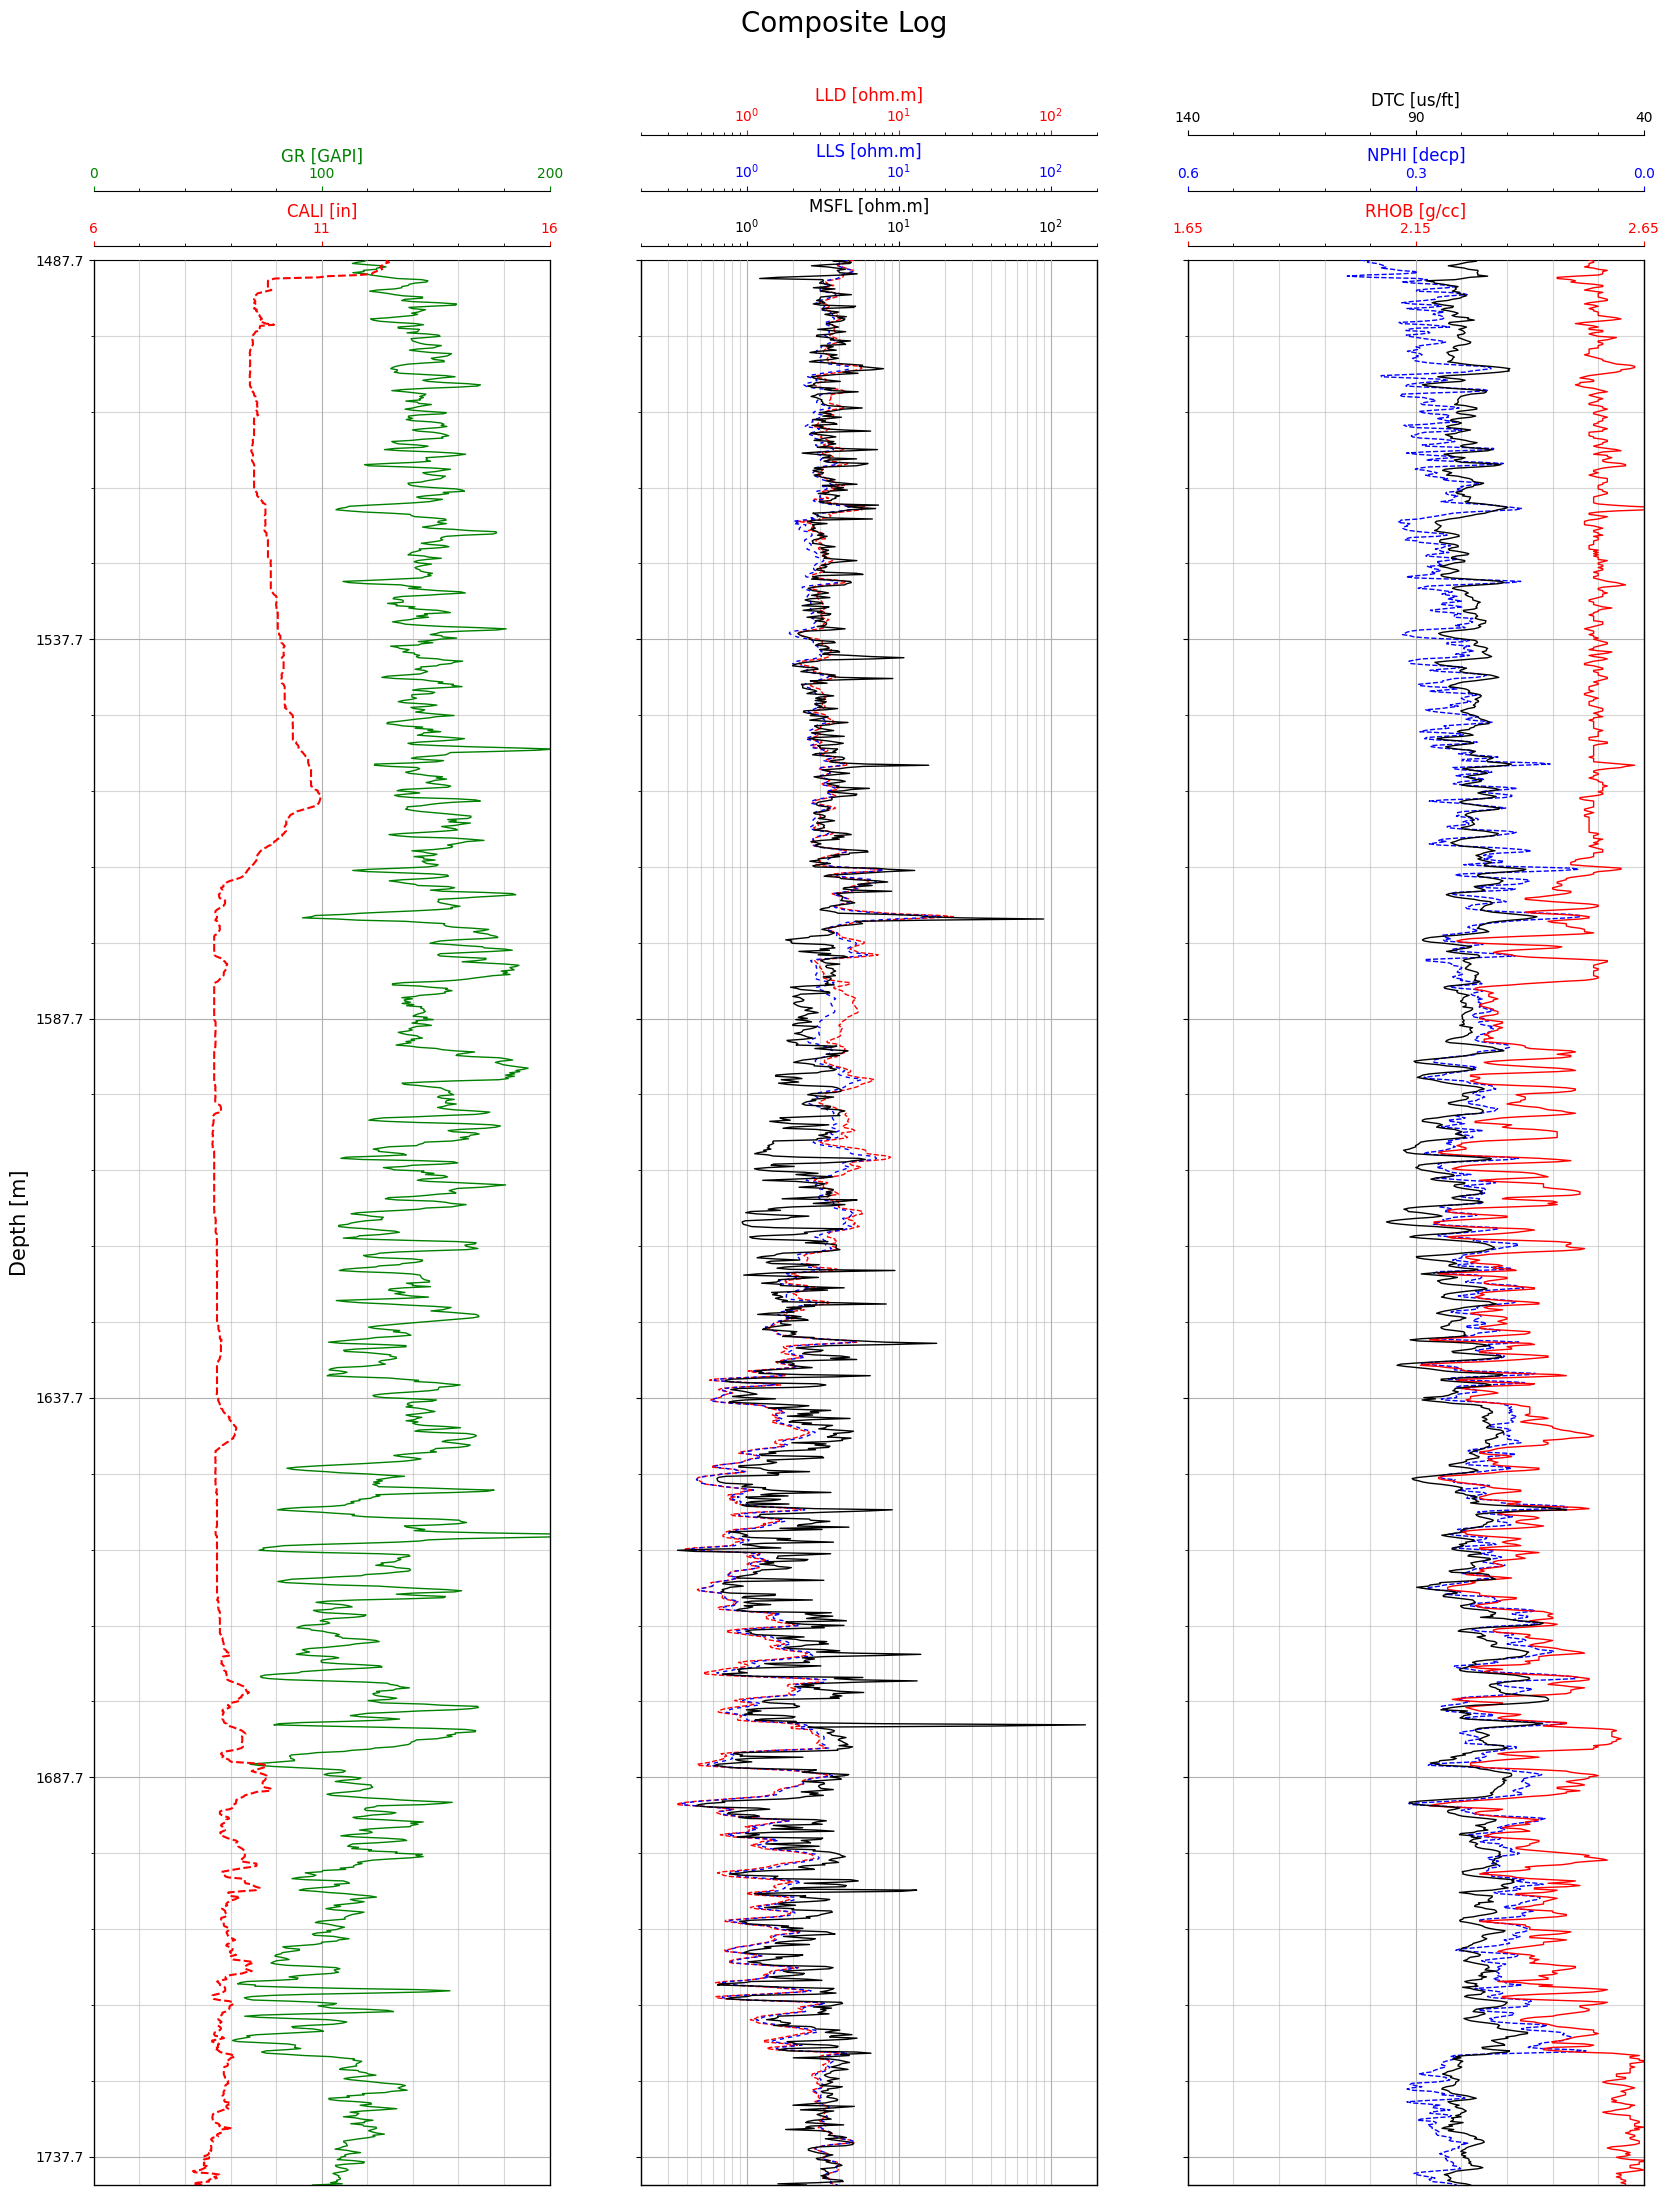

In [6]:
#Visualise the log

def wireline_log_plotting(top,bottom,las):
    '''
    Plot wireline log

    Args:
        top: the top depth of the log
        bottom: the bottom depth of the log
        las: LASFile to plot
    '''

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,25),sharey=True)
    fig.suptitle("Composite Log", fontsize=20)
    fig.subplots_adjust(top=0.88)

    for axes in ax:
        axes.set_ylim(bottom,top)
        depth_major_ticks = np.arange(top, bottom, 50)
        depth_minor_ticks = np.arange(top, bottom, 10)
        axes.set_yticks(depth_major_ticks)
        axes.set_yticks(depth_minor_ticks, minor=True)
        axes.get_xaxis().set_visible(False)
        axes.grid(which='minor', axis='y', alpha=0.5)
        axes.grid(which='major', axis='y', alpha=1)


    ax[0].set_ylabel("Depth [m]",color="Black",fontsize=15)

    #Track 1: GR and CALI
    #GR
    ax_GR=ax[0].twiny()
    ax_GR.set_xlim(0,200)
    ax_GR.set_xlabel('GR [GAPI]',color="Green",fontsize=12)
    ax_GR.plot(las['GR'],las['DEPTH'],color="Green",label='GR [GAPI]',linewidth=1)
    ax_GR.tick_params(axis='x', colors='Green')
    ax_GR.spines['top'].set_position(('outward',50))
    major_ticks = np.arange(0, 201, 100)
    minor_ticks = np.arange(0, 201, 20)
    ax_GR.set_xticks(major_ticks)
    ax_GR.set_xticks(minor_ticks, minor=True)
    ax_GR.grid(which='minor', alpha=0.5)
    ax_GR.grid(which='major', alpha=1)

    #CALI
    ax_CALI=ax[0].twiny()
    ax_CALI.set_xlim(6,16)
    ax_CALI.set_xlabel('CALI [in]',color="Red",fontsize=12)
    ax_CALI.plot(las['CALI'],las['DEPTH'],'--',color="Red",label='CALI [in]')
    ax_CALI.tick_params(axis='x', colors='Red')
    ax_CALI.spines['top'].set_position(('outward',10))
    major_ticks = np.arange(6, 17, 5)
    minor_ticks = np.arange(6, 17, 1)
    ax_CALI.set_xticks(major_ticks)
    ax_CALI.set_xticks(minor_ticks, minor=True)

    #Track 2: Resistivity

    #LLD
    ax_LLD=ax[1].twiny()
    ax_LLD.set_xscale('log')
    ax_LLD.set_xlim(0.2,200)
    ax_LLD.set_xlabel('LLD [ohm.m]',color="Red",fontsize=12)
    ax_LLD.plot(las['LLD'],las['DEPTH'],'--',color="Red",label='LLD [ohm.m]',linewidth=1)
    ax_LLD.tick_params(axis='x', colors='Red')
    ax_LLD.spines['top'].set_position(('outward',90))
    ax_LLD.grid(which='minor', alpha=0.5)
    ax_LLD.grid(which='major', alpha=1)

    #LLS
    ax_LLS=ax[1].twiny()
    ax_LLS.set_xscale('log')
    ax_LLS.set_xlim(0.2,200)
    ax_LLS.set_xlabel('LLS [ohm.m]',color="Blue",fontsize=12)
    ax_LLS.plot(las['LLS'],las['DEPTH'],'--',color="Blue",label='LLS [ohm.m]',dashes=[3,3],linewidth=1)
    ax_LLS.tick_params(axis='x', colors='Blue')
    ax_LLS.spines['top'].set_position(('outward',50))

    #MSFL
    ax_MSFL=ax[1].twiny()
    ax_MSFL.set_xscale('log')
    ax_MSFL.set_xlim(0.2,200)
    ax_MSFL.set_xlabel('MSFL [ohm.m]',color="Black",fontsize=12)
    ax_MSFL.plot(las['MSFL'],las['DEPTH'],color="Black",label='MSFL [ohm.m]',linewidth=1)
    ax_MSFL.spines['top'].set_position(('outward',10))

    #Track 3: NPHI, RHOB, DTC, PET
    #NPHI
    ax_NEU=ax[2].twiny()
    ax_NEU.set_xlim(0.6,0)
    ax_NEU.set_xlabel('NPHI [decp]',color="Blue",fontsize=12)
    ax_NEU.plot(las['NPHI'],las['DEPTH'],'--',color="Blue",label='NPHI [decp]',linewidth=1)
    ax_NEU.tick_params(axis='x', colors='Blue')
    ax_NEU.spines['top'].set_position(('outward',50))
    major_ticks = np.arange(0, 0.61, 0.3)
    minor_ticks = np.arange(0, 0.61, 0.06)
    ax_NEU.set_xticks(major_ticks)
    ax_NEU.set_xticks(minor_ticks, minor=True)
    ax_NEU.grid(which='minor', alpha=0.5)
    ax_NEU.grid(which='major', alpha=1)

    #RHOB
    ax_RHOB=ax[2].twiny()
    ax_RHOB.set_xlim(1.65,2.65)
    ax_RHOB.set_xlabel('RHOB [g/cc]',color="Red",fontsize=12)
    ax_RHOB.plot(las['RHOB'],las['DEPTH'],color="Red",label='RHOB [g/cc]',linewidth=1)
    ax_RHOB.tick_params(axis='x', colors='Red')
    ax_RHOB.spines['top'].set_position(('outward',10))
    major_ticks = np.arange(1.65, 2.66, 0.5)
    minor_ticks = np.arange(1.65, 2.66, 0.1)
    ax_RHOB.set_xticks(major_ticks)
    ax_RHOB.set_xticks(minor_ticks, minor=True)

    #DTC
    ax_DTC=ax[2].twiny()
    ax_DTC.set_xlim(140,40)
    ax_DTC.set_xlabel('DTC [us/ft]',color="Black",fontsize=12)
    ax_DTC.plot(las['DTC'],las['DEPTH'],color="Black",label='DTC [us/ft]',linewidth=1)
    ax_DTC.spines['top'].set_position(('outward',90))
    major_ticks = np.arange(40, 141, 50)
    minor_ticks = np.arange(40, 141, 10)
    ax_DTC.set_xticks(major_ticks)
    ax_DTC.set_xticks(minor_ticks, minor=True)

    fig.savefig("wireline_log.jpg")

top = las_df_well_1['DEPTH'].min()
bottom = las_df_well_1['DEPTH'].max()

wireline_log_plotting(top,bottom,las_df_well_1)

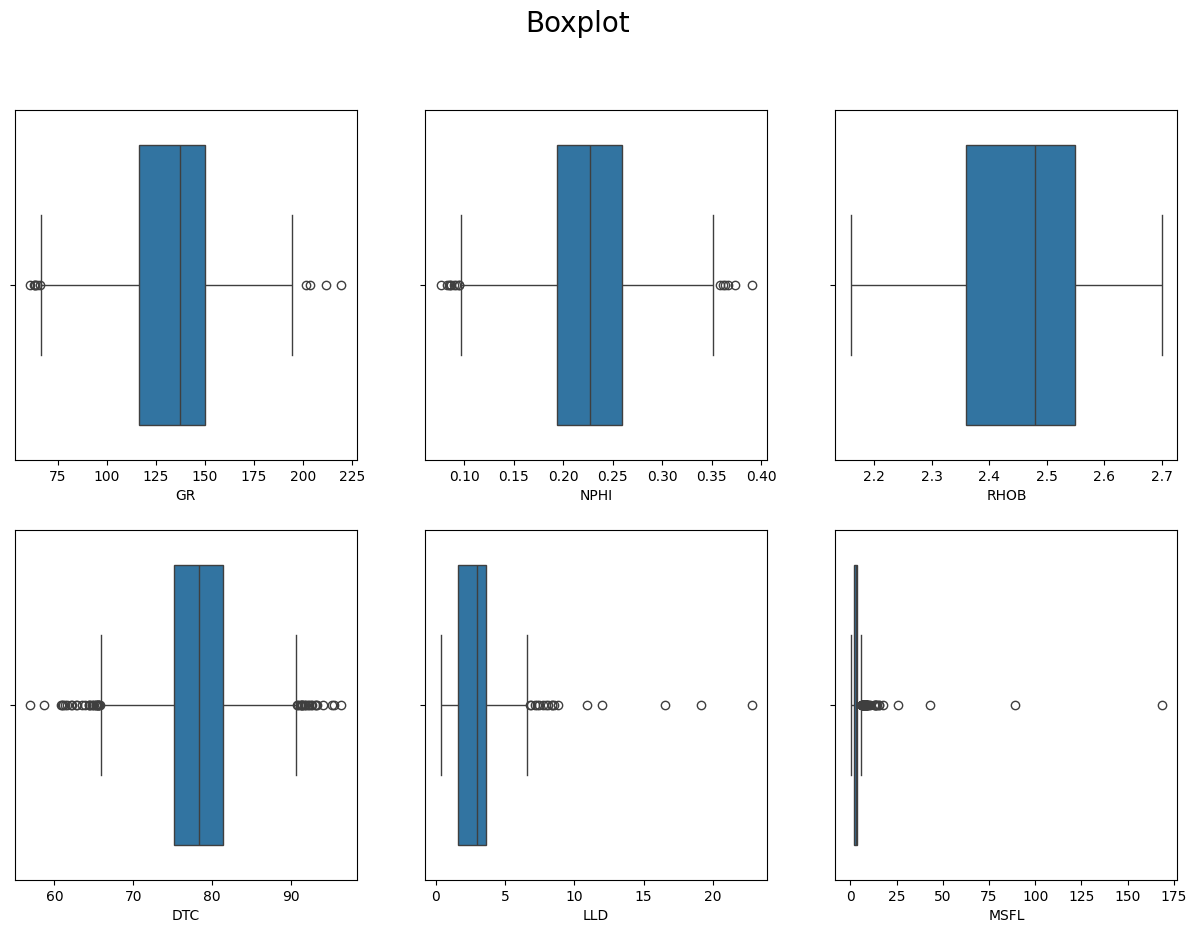

In [7]:
#draw boxplot of each main curve

def box_plot(df):

    ncols=3
    nrows=2

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,10))
    fig.suptitle("Boxplot", fontsize=20)

    for axis in ax.flat:
        axis.set(xlabel='Value')

    sns.boxplot(x=df['GR'], ax=ax[0][0])
    ax[0][0].set_xlabel('GR')
    sns.boxplot(x=df['NPHI'], ax=ax[0][1])
    ax[0][1].set_xlabel('NPHI')

    sns.boxplot(x=df['RHOB'], ax=ax[0][2])
    ax[0][2].set_xlabel('RHOB')

    sns.boxplot(x=df['DTC'], ax=ax[1][0])
    ax[1][0].set_xlabel('DTC')

    sns.boxplot(x=df['LLD'], ax=ax[1][1])
    ax[1][1].set_xlabel('LLD')

    sns.boxplot(x=df['MSFL'], ax=ax[1][2])
    ax[1][2].set_xlabel('MSFL')

    fig.savefig("boxplot.jpg")

box_plot(las_df_well_1)


The boxplot is used to identify the outliers in the data. Here, we can see the outliers in LLD and MSFL data columns. We are going to take a deeper look into this.

<ipython-input-8-8dea4099ef84>:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['GR'],ax=ax[0][0],norm_hist=True)
<ipython-input-8-8dea4099ef84>:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['NPHI'],ax=ax[0][1],norm_hist=True)
<ipython-input-8-8dea4099ef84>:16: UserWarning: 

`distplo

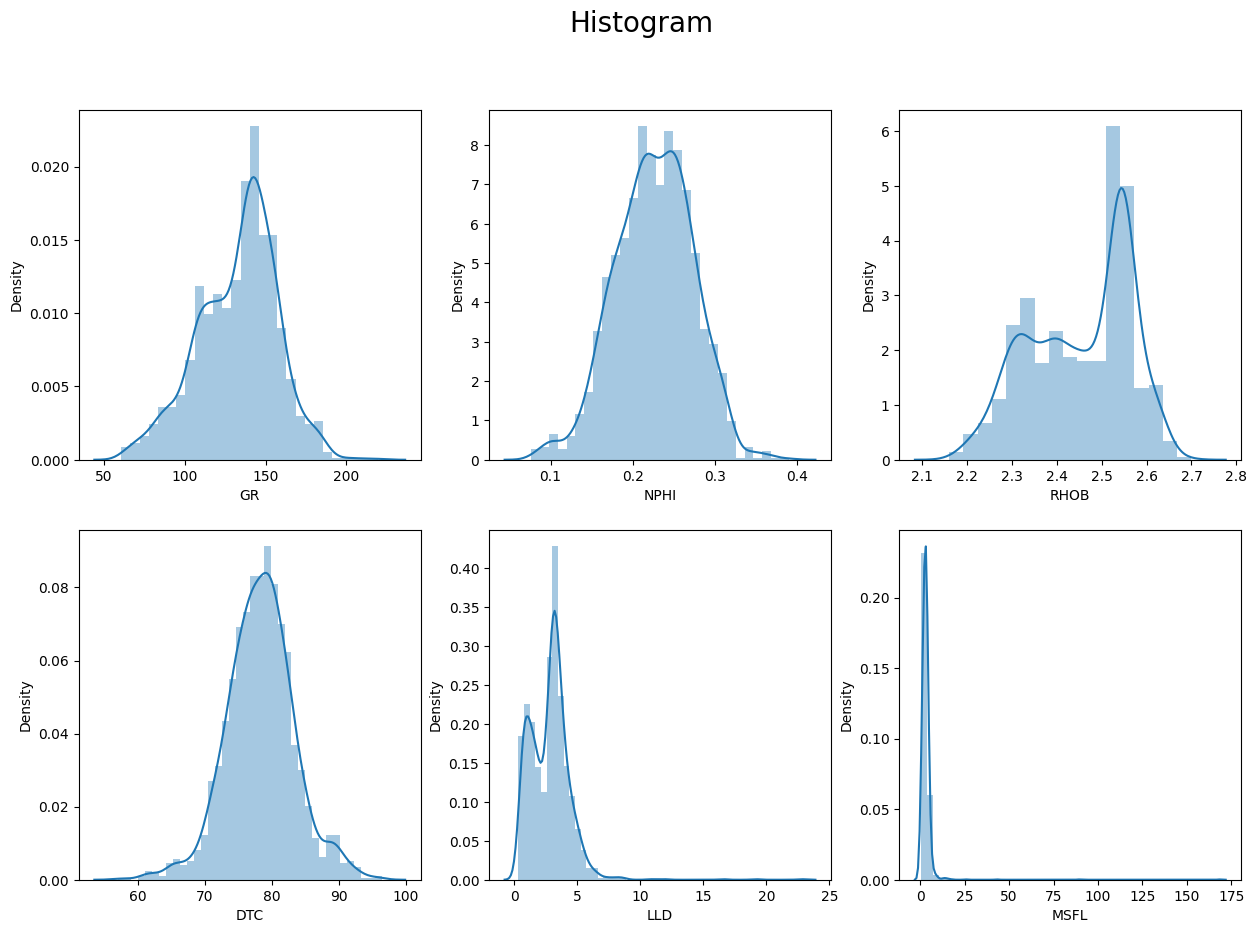

In [8]:
#histogram of each main curve

def histogram_plot(df):

    ncols=3
    nrows=2

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,10))
    fig.suptitle("Histogram", fontsize=20)

    for axis in ax.flat:
        axis.set(xlabel='Value')

    sns.distplot(df['GR'],ax=ax[0][0],norm_hist=True)
    sns.distplot(df['NPHI'],ax=ax[0][1],norm_hist=True)
    sns.distplot(df['RHOB'],ax=ax[0][2],norm_hist=True)
    sns.distplot(df['DTC'],ax=ax[1][0],norm_hist=True)
    sns.distplot(df['LLD'],ax=ax[1][1],norm_hist=True)
    sns.distplot(df['MSFL'],ax=ax[1][2],norm_hist=True)

histogram_plot(las_df_well_1)

In [9]:
#Check the outliers in MSFL

las_df_well_1[las_df_well_1['MSFL']>75]

CALI    DTC        GR      LLD     LLS      MSFL    NPHI     PEF  \
DEPTH                                                                           
1574.5968  8.6801  66.00  106.6490  10.8908  9.1666   89.3277  0.1285  3.2291   
1680.8196  8.9148  64.75   79.0245   2.1735  2.4218  168.4890  0.1213  2.9129   

             POTA  RHOB      SGR    THOR    URAN   AZIMUTH     INC  \
DEPTH                                                                
1574.5968  4.4986  2.51  103.821  6.9006  0.7095  132.4959  0.6837   
1680.8196  2.3072  2.45   76.456  6.5157  1.8656  145.4583  0.4259   

               EASTING    NORTHING        TVD      DEPTH  
DEPTH                                                     
1574.5968  400945.2188  87033.7813  1574.1265  1574.5968  
1680.8196  400945.8125  87033.0313  1680.3447  1680.8196

In [10]:
# Calculate IQR
Q1 = las_df_well_1['MSFL'].quantile(0.25)
Q3 = las_df_well_1['MSFL'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier threshold
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = las_df_well_1[(las_df_well_1['MSFL'] < lower_bound) | (las_df_well_1['MSFL'] > upper_bound)]
print("Number of outliers in MSFL:", outliers.shape[0])
outliers[['MSFL']]

Number of outliers in MSFL: 51


MSFL
DEPTH              
1501.9020    6.6118
1502.0544    7.9009
1502.2068    6.6781
1510.2840    6.5041
1512.7224    7.2206
1514.5512    6.2480
1520.0376    7.3279
1520.4948    7.0151
1521.8664    6.6754
1540.0020    6.5207
1540.1544   10.7714
1540.3068    6.8321
1542.8976    9.1010
1554.1752    6.2213
1554.3276   15.6872
1557.3756    6.3811
1565.6052    6.1679
1565.7576    6.2539
1567.8912    6.9362
1568.0436    8.5941
1568.1960   12.6757
1568.3484    8.4372
1568.5008    6.4957
1569.5676    7.2380
1569.7200    8.4258
1569.8724    6.3334
1570.1772    6.6595
1570.9392    8.9425
1573.9872    8.3954
1574.1396   13.8385
1574.2920   14.6494
1574.4444   25.6991
1574.5968   89.3277
1574.7492   15.5453
1620.9264    9.4001
1625.3460    8.2368
1630.3752    8.1618
1630.5276   17.6927
1630.6800    8.9671
1634.7948    6.4692
1652.4732    9.0224
1652.6256    6.2123
1671.5232   13.9132
1671.6756    7.5989
1675.0284   13.1552
1680.6672    7.7588
1680.8196  168.4890
1680.9720   43.0761
1702.6128   13.0748
1702.7652   10.3164
1724.1012    6.5384

In [11]:
# Remove outliers
# Build a Boolean mask of valid rows
mask = (las_df_well_1['MSFL'] >= lower_bound) & (las_df_well_1['MSFL'] <= upper_bound)

#Apply the mask to remove outliers
las_df_well_1_removed_outliers = las_df_well_1[mask].copy()

#Reset index
las_df_well_1_removed_outliers.reset_index(drop=True, inplace=True)

las_df_well_1_removed_outliers.head()

CALI    DTC       GR     LLD     LLS    MSFL    NPHI     PEF    POTA  \
0  12.4378  76.81  119.373  5.0465  4.6057  4.2766  0.3733  3.3767  3.4000   
1  12.4228  76.69  118.905  4.7519  4.4229  3.6847  0.3619  3.3475  3.4000   
2  12.4752  78.75  115.521  4.4015  4.1144  4.8480  0.3636  3.2653  3.4045   
3  12.3841  79.88  113.471  4.2874  4.0418  4.7533  0.3513  3.2798  3.7958   
4  12.3665  81.06  119.375  4.0245  3.8622  3.3685  0.3460  3.3632  3.8998   

   RHOB      SGR     THOR    URAN   AZIMUTH     INC      EASTING    NORTHING  \
0  2.53  125.869  10.3179  4.1150  159.9219  2.2297  400944.1875  87036.5000   
1  2.54  128.924  10.5556  4.2309  159.9514  2.2370  400944.1875  87036.4922   
2  2.54  126.191  10.2088  4.1058  159.9810  2.2444  400944.1875  87036.4922   
3  2.53  133.917  10.2958  4.2836  160.0106  2.2518  400944.1875  87036.4844   
4  2.53  136.002  10.2981  4.3744  160.0401  2.2592  400944.1875  87036.4766   

         TVD      DEPTH  
0  1487.3195  1487.7288  
1  1487.4718  1487.8812  
2  1487.6240  1488.0336  
3  1487.7764  1488.1860  
4  1487.9286  1488.3384

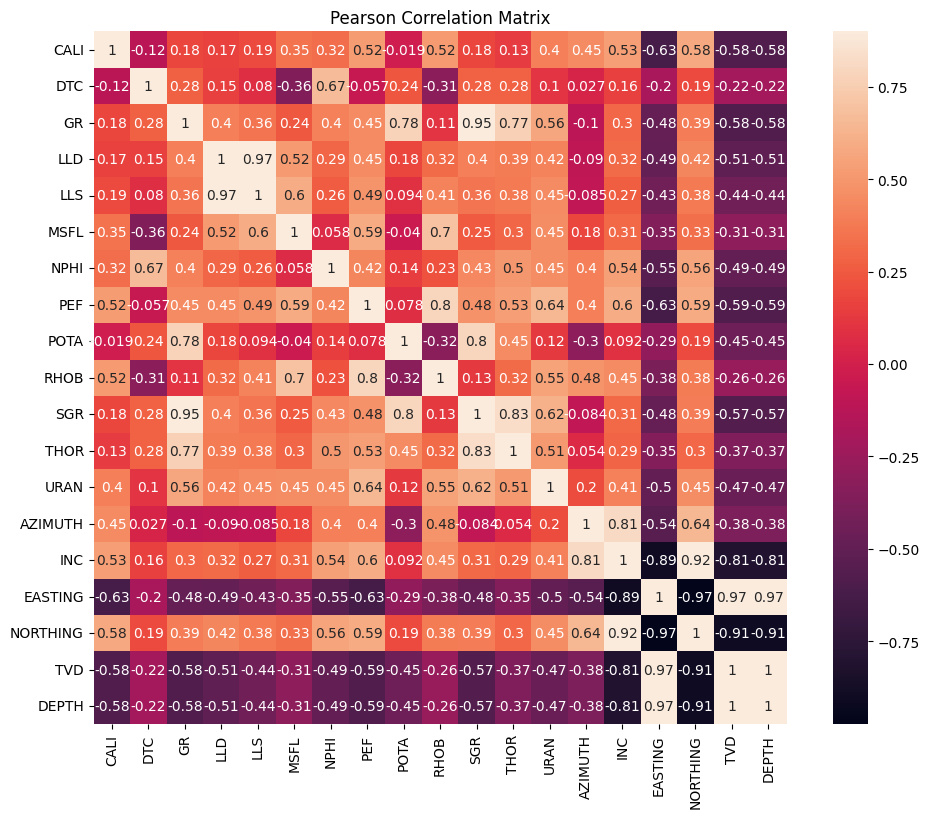

In [12]:
#Plotting heat correlation map between features to see collinearities

def plot_heatmap(las):
    '''
    Plot heatmap between features
    '''
    corr_matrix = las.corr()
    plt.subplots(figsize=(12,9))
    plt.title('Pearson Correlation Matrix')
    sns.heatmap(corr_matrix, vmax=0.9, square=True, annot=True)

plot_heatmap(las_df_well_1_removed_outliers)

###Key Insights from the Correlation Matrix:

**1. Very High Correlation Between Resistivity Logs**


*   LLD and LLS → 0.97
*   LLD and GR → 0.95

*  LLD and LLS are almost identical in behaviour. We can Eliminate one feature while model training to avoid multicollinearity.



**2. Strong Correlation Among Spectral Gamma Ray Logs**

*   SGR, THOR, URAN → 0.8+
*   SGR and GR → 0.95

*   These gamma ray logs are highly redundant. We can use only one (e.g, SGR or GR)  to reduce dimensionality.

###**Feature Selection:**
Here, we will extract the commonly used logs (triple combo) that we will use for further analysis. These features are as below:

GR, NPHI, RHOB, DTC, LLD, MSFL - these are essential for lithology and porosity evaluation

In [13]:
#for our analysis we will only select Triple Combo Curves

def get_triple_combo(df):
    '''
    Get only Triple Combo curves
    '''
    out = df[['DEPTH','GR','NPHI','RHOB','DTC','LLD','MSFL']]
    out.index = pd.RangeIndex(len(out.index))
    return out

las_df_well_1_TC = get_triple_combo(las_df_well_1_removed_outliers)
las_df_well_1_TC.head()

DEPTH       GR    NPHI  RHOB    DTC     LLD    MSFL
0  1487.7288  119.373  0.3733  2.53  76.81  5.0465  4.2766
1  1487.8812  118.905  0.3619  2.54  76.69  4.7519  3.6847
2  1488.0336  115.521  0.3636  2.54  78.75  4.4015  4.8480
3  1488.1860  113.471  0.3513  2.53  79.88  4.2874  4.7533
4  1488.3384  119.375  0.3460  2.53  81.06  4.0245  3.3685

###**Feature Scaling:**
We will transform the values of features to a consistent range or scale. This process helps to ensure that all features contribute equally to the learning process, preventing features with larger ranges from dominating the model's performance

Here, we haven't scaled DEPTH as it is a reference column, not a true input feature. It indicates the vertical position in the well, not a measurable rock or fluid property.

In [14]:
def scaling_features(df_in):
    '''
    scale the features between 0 to 1
    Args:
        df_in: input dataframe to be scaled
    Returns:
        df_scaled: the new scaled dataframe
    '''

    scaler = MinMaxScaler()
    df_temp = df_in
    df_scaled = pd.DataFrame(scaler.fit_transform(df_in), columns=df_in.columns)
    df_scaled['DEPTH'] = df_temp['DEPTH']
    return df_scaled

df_scaled_well_1 = scaling_features(las_df_well_1_TC)
df_scaled_well_1.head()

DEPTH        GR      NPHI      RHOB       DTC       LLD      MSFL
0  1487.7288  0.368534  0.945894  0.711538  0.480000  0.556249  0.694313
1  1487.8812  0.365587  0.909612  0.730769  0.476821  0.521411  0.589684
2  1488.0336  0.344279  0.915022  0.730769  0.531391  0.479973  0.795319
3  1488.1860  0.331371  0.875875  0.711538  0.561325  0.466480  0.778579
4  1488.3384  0.368546  0.859007  0.711538  0.592583  0.435390  0.533789

###**Cluster the triple combo curves:**

We will use the elbow method to determine the optimal number of clusters.


*   We iterate over a range of k values, typically from 1 to n
*   For each k, we calculate the Within-Cluster Sum of Squares (WCSS).

WCSS measures how well the data points are clustered around their respective centroids. It is defined as the sum of the squared distances between each point and its cluster centroid:



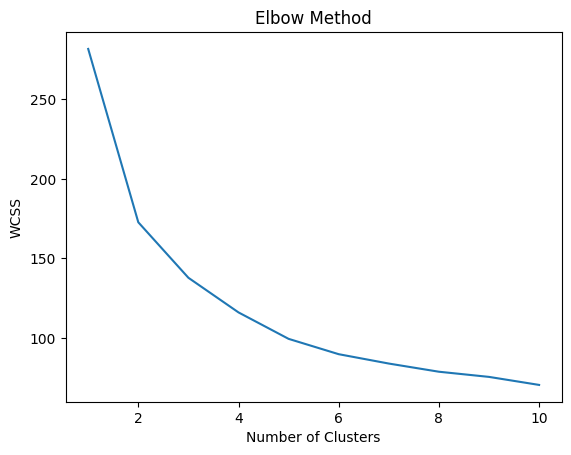

In [15]:
#find the optimum number of clusters using WCSS Elbow Method
#we remove depth from clustering

def find_K(df):
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(df.drop(['DEPTH'],axis=1))
        wcss.append(kmeans.inertia_)
    plt.plot(range(1, 11), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.show()

find_K(df_scaled_well_1)

We will take K=3 based on the above figure.

In [16]:
def clustering(df,n_clusters):
    #run the K-means clustering

    kmeans = KMeans(n_clusters=n_clusters)
    k_means = kmeans.fit(df.drop(['DEPTH'],axis=1))
    labels = k_means.labels_

    #save the clustering results in the new column
    df['cluster']=k_means.labels_
    return df

df_scaled_well_1 = clustering(df_scaled_well_1,n_clusters=3)
df_scaled_well_1.head()

DEPTH        GR      NPHI      RHOB       DTC       LLD      MSFL  \
0  1487.7288  0.368534  0.945894  0.711538  0.480000  0.556249  0.694313   
1  1487.8812  0.365587  0.909612  0.730769  0.476821  0.521411  0.589684   
2  1488.0336  0.344279  0.915022  0.730769  0.531391  0.479973  0.795319   
3  1488.1860  0.331371  0.875875  0.711538  0.561325  0.466480  0.778579   
4  1488.3384  0.368546  0.859007  0.711538  0.592583  0.435390  0.533789   

   cluster  
0        2  
1        2  
2        2  
3        2  
4        2

In [17]:
#load the facies data from geologist
df_facies = pd.read_csv("/content/drive/MyDrive/well_1_facies.csv")
df_facies.head()

Top Depth (mBRT)  Bottom Depth (mBRT)  Facies
0            1565.0               1577.5       2
1            1577.5               1580.0       1
2            1580.0               1584.0       2
3            1584.0               1591.0       3
4            1591.0               1596.0       1

In [18]:
#Add cluster column to the unscaled dataframe
las_df_well_1_TC['cluster'] = df_scaled_well_1['cluster']
las_df_well_1_TC.head()

<ipython-input-18-57376c654d4f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  las_df_well_1_TC['cluster'] = df_scaled_well_1['cluster']


DEPTH       GR    NPHI  RHOB    DTC     LLD    MSFL  cluster
0  1487.7288  119.373  0.3733  2.53  76.81  5.0465  4.2766        2
1  1487.8812  118.905  0.3619  2.54  76.69  4.7519  3.6847        2
2  1488.0336  115.521  0.3636  2.54  78.75  4.4015  4.8480        2
3  1488.1860  113.471  0.3513  2.53  79.88  4.2874  4.7533        2
4  1488.3384  119.375  0.3460  2.53  81.06  4.0245  3.3685        2

###**Visualizing Cluster Distributions with Boxplots**

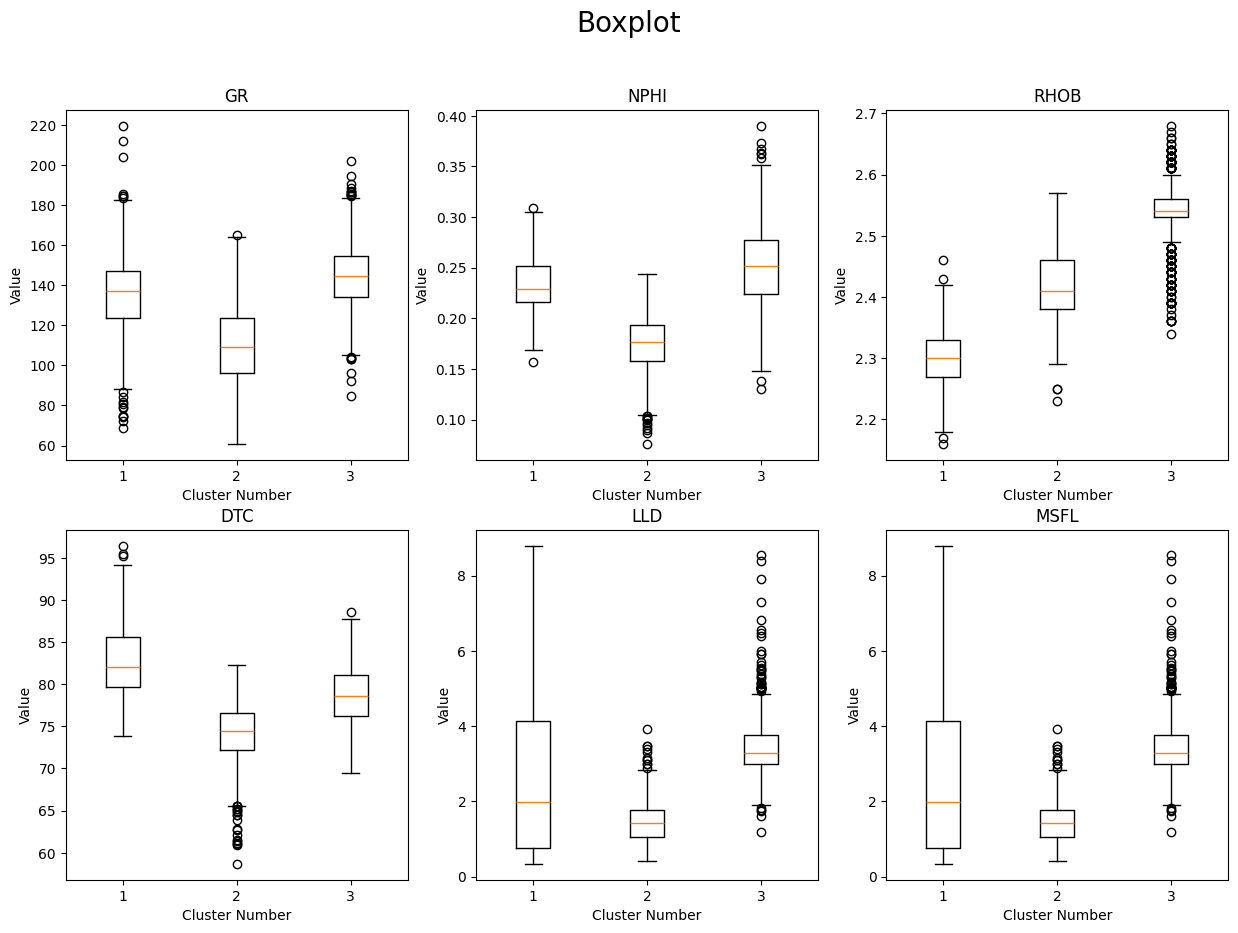

In [19]:
def cluster_boxplot(df,n_clusters):
    #boxplot of each cluster

    ncols=3
    nrows=2

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,10))
    fig.suptitle("Boxplot", fontsize=20)
    # fig.subplots_adjust(top=0.88)

    for axis in ax.flat:
        axis.set(xlabel='Cluster Number', ylabel="Value")

    data_to_plot_1=[]
    data_to_plot_2=[]
    data_to_plot_3=[]
    data_to_plot_4=[]
    data_to_plot_5=[]


    for i in range(n_clusters):
        data_to_plot_1.append(df['GR'].loc[df['cluster']==i])
        data_to_plot_2.append(df['NPHI'].loc[df['cluster']==i])
        data_to_plot_3.append(df['RHOB'].loc[df['cluster']==i])
        data_to_plot_4.append(df['DTC'].loc[df['cluster']==i])
        data_to_plot_5.append(df['LLD'].loc[df['cluster']==i])


    # Create the boxplot
    ax[0][0].boxplot(data_to_plot_1)
    ax[0][0].set_title("GR")

    ax[0][1].boxplot(data_to_plot_2)
    ax[0][1].set_title("NPHI")

    ax[0][2].boxplot(data_to_plot_3)
    ax[0][2].set_title("RHOB")

    ax[1][0].boxplot(data_to_plot_4)
    ax[1][0].set_title("DTC")

    ax[1][1].boxplot(data_to_plot_5)
    ax[1][1].set_title("LLD");

    ax[1][2].boxplot(data_to_plot_5)
    ax[1][2].set_title("MSFL");

cluster_boxplot(las_df_well_1_TC,3)

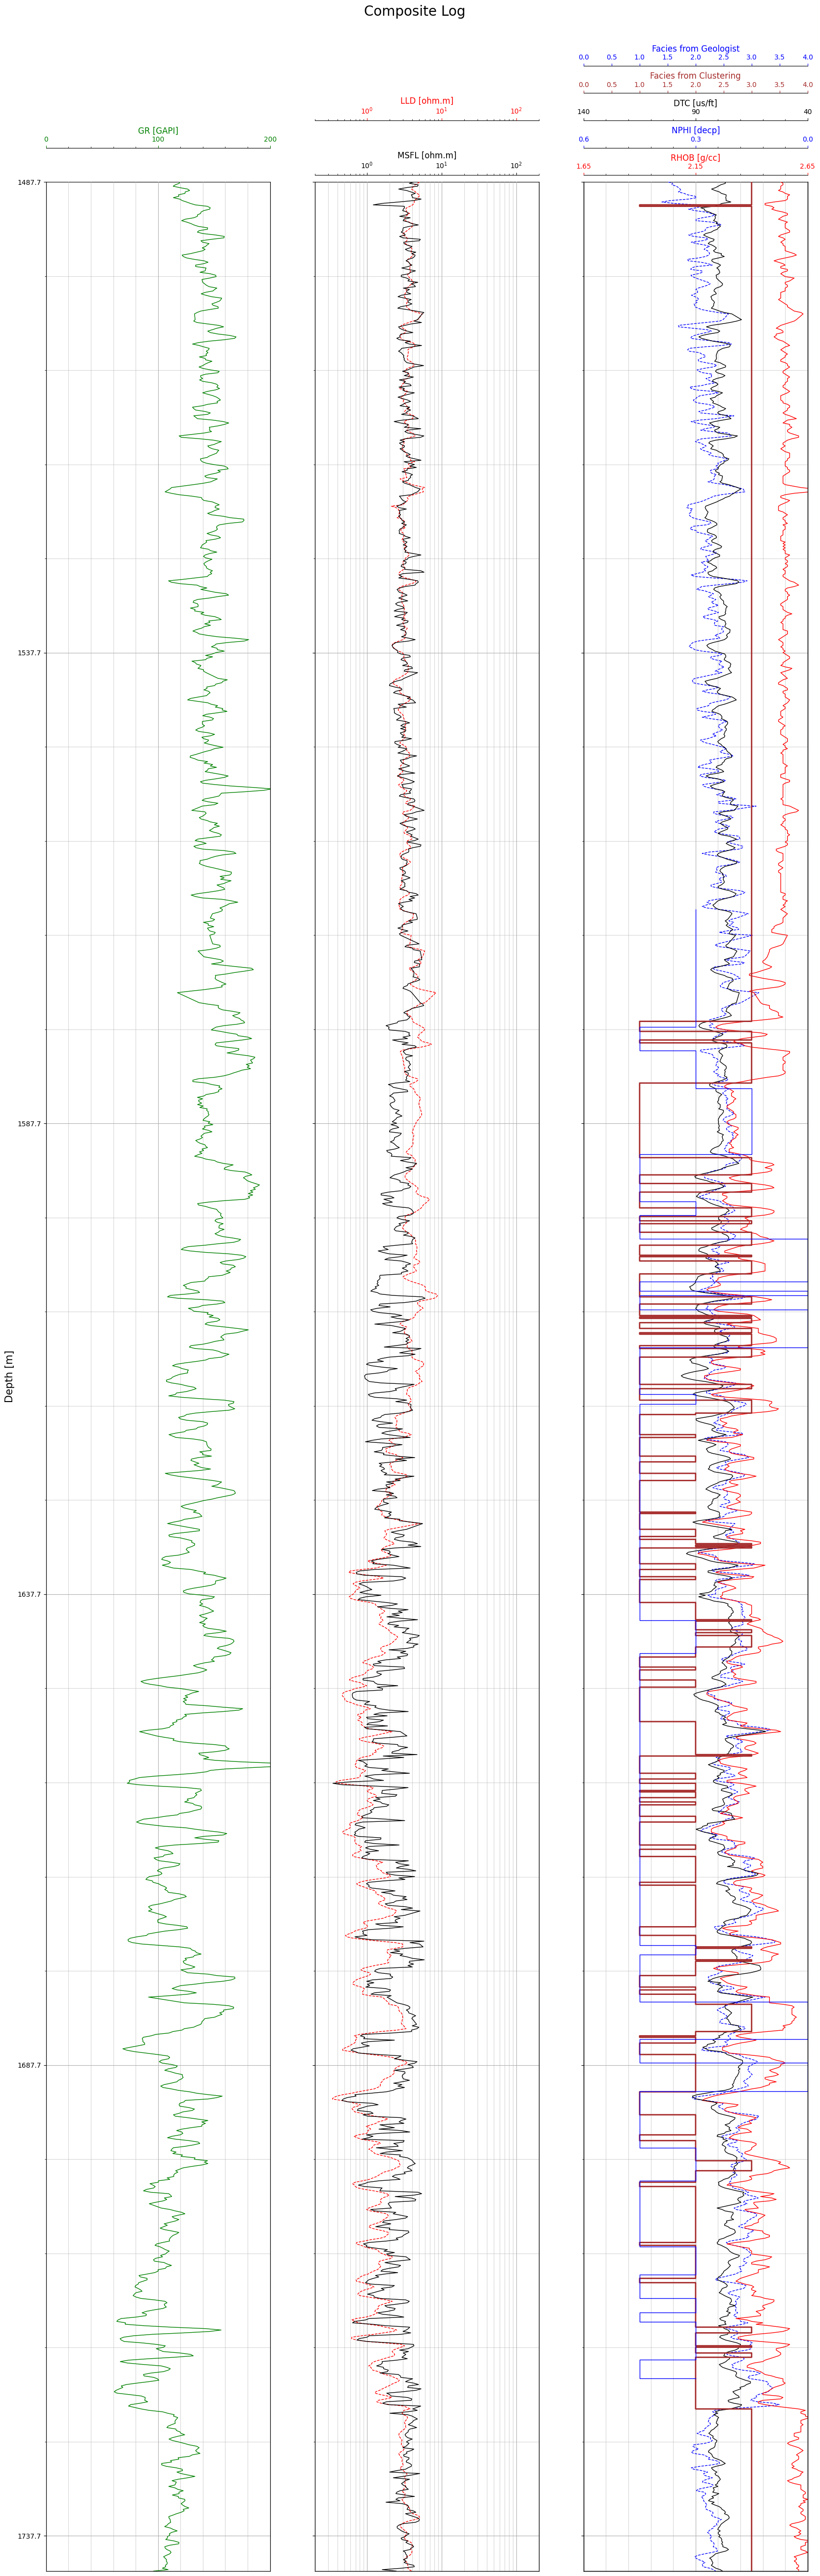

In [20]:
def plot_facies(df,df_facies):
    '''
    Plot facies identified by geologist compared with clustering results
    '''
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,60),sharey=True)
    fig.suptitle("Composite Log", fontsize=20)
    fig.subplots_adjust(top=0.92)

    top = df['DEPTH'].min()
    bottom = df['DEPTH'].max()

    for axes in ax:
        axes.set_ylim(bottom,top)
        depth_major_ticks = np.arange(top, bottom, 50)
        depth_minor_ticks = np.arange(top, bottom, 10)
        axes.set_yticks(depth_major_ticks)
        axes.set_yticks(depth_minor_ticks, minor=True)
        axes.get_xaxis().set_visible(False)
        axes.grid(which='minor', axis='y', alpha=0.5)
        axes.grid(which='major', axis='y', alpha=1)


    ax[0].set_ylabel("Depth [m]",color="Black",fontsize=15)

    #Track 1: GR and CALI
    #GR
    ax_GR=ax[0].twiny()
    ax_GR.set_xlim(0,200)
    ax_GR.set_xlabel('GR [GAPI]',color="Green",fontsize=12)
    ax_GR.plot(df['GR'],df['DEPTH'],color="Green",label='GR [GAPI]',linewidth=1)
    ax_GR.tick_params(axis='x', colors='Green')
    ax_GR.spines['top'].set_position(('outward',50))
    major_ticks = np.arange(0, 201, 100)
    minor_ticks = np.arange(0, 201, 20)
    ax_GR.set_xticks(major_ticks)
    ax_GR.set_xticks(minor_ticks, minor=True)
    ax_GR.grid(which='minor', alpha=0.5)
    ax_GR.grid(which='major', alpha=1)


    #Track 2: Resistivity
    #LLD
    ax_LLD=ax[1].twiny()
    ax_LLD.set_xscale('log')
    ax_LLD.set_xlim(0.2,200)
    ax_LLD.set_xlabel('LLD [ohm.m]',color="Red",fontsize=12)
    ax_LLD.plot(df['LLD'],df['DEPTH'],'--',color="Red",label='LLD [ohm.m]',linewidth=1)
    ax_LLD.tick_params(axis='x', colors='Red')
    ax_LLD.spines['top'].set_position(('outward',90))
    ax_LLD.grid(which='minor', alpha=0.5)
    ax_LLD.grid(which='major', alpha=1)

    #MSFL
    ax_MSFL=ax[1].twiny()
    ax_MSFL.set_xscale('log')
    ax_MSFL.set_xlim(0.2,200)
    ax_MSFL.set_xlabel('MSFL [ohm.m]',color="Black",fontsize=12)
    ax_MSFL.plot(df['MSFL'],df['DEPTH'],color="Black",label='MSFL [ohm.m]',linewidth=1)
    ax_MSFL.spines['top'].set_position(('outward',10))


    #Track 3: NPHI, RHOB, DTC, PET
    #NPHI
    ax_NEU=ax[2].twiny()
    ax_NEU.set_xlim(0.6,0)
    ax_NEU.set_xlabel('NPHI [decp]',color="Blue",fontsize=12)
    ax_NEU.plot(df['NPHI'],df['DEPTH'],'--',color="Blue",label='NPHI [decp]',linewidth=1)
    ax_NEU.tick_params(axis='x', colors='Blue')
    ax_NEU.spines['top'].set_position(('outward',50))
    major_ticks = np.arange(0, 0.61, 0.3)
    minor_ticks = np.arange(0, 0.61, 0.06)
    ax_NEU.set_xticks(major_ticks)
    ax_NEU.set_xticks(minor_ticks, minor=True)
    ax_NEU.grid(which='minor', alpha=0.5)
    ax_NEU.grid(which='major', alpha=1)

    #RHOB
    ax_RHOB=ax[2].twiny()
    ax_RHOB.set_xlim(1.65,2.65)
    ax_RHOB.set_xlabel('RHOB [g/cc]',color="Red",fontsize=12)
    ax_RHOB.plot(df['RHOB'],df['DEPTH'],color="Red",label='RHOB [g/cc]',linewidth=1)
    ax_RHOB.tick_params(axis='x', colors='Red')
    ax_RHOB.spines['top'].set_position(('outward',10))
    major_ticks = np.arange(1.65, 2.66, 0.5)
    minor_ticks = np.arange(1.65, 2.66, 0.1)
    ax_RHOB.set_xticks(major_ticks)
    ax_RHOB.set_xticks(minor_ticks, minor=True)

    #DTC
    ax_DTC=ax[2].twiny()
    ax_DTC.set_xlim(140,40)
    ax_DTC.set_xlabel('DTC [us/ft]',color="Black",fontsize=12)
    ax_DTC.plot(df['DTC'],df['DEPTH'],color="Black",label='DTC [us/ft]',linewidth=1)
    ax_DTC.spines['top'].set_position(('outward',90))
    major_ticks = np.arange(40, 141, 50)
    minor_ticks = np.arange(40, 141, 10)
    ax_DTC.set_xticks(major_ticks)
    ax_DTC.set_xticks(minor_ticks, minor=True)

    #FACIES FROM CLUSTERING
    ax_fc=ax[2].twiny()
    ax_fc.set_xlim(0,4)
    ax_fc.set_xlabel('Facies from Clustering',color="Brown",fontsize=12)
    ax_fc.step(df['cluster']+1,df['DEPTH'],color="Brown",label='Cluster',linewidth=2)
    ax_fc.tick_params(axis='x', colors='Brown')
    ax_fc.spines['top'].set_position(('outward',130))

    #FACIES FROM GEOLOGIST
    ax_fc2=ax[2].twiny()
    ax_fc2.set_xlim(0,4)
    ax_fc2.set_xlabel('Facies from Geologist',color="Blue",fontsize=12)
    ax_fc2.step(df_facies['Facies'],df_facies['Top Depth (mBRT)'],color="Blue",label='Facies',linewidth=1)
    ax_fc2.tick_params(axis='x', colors='Blue')
    ax_fc2.spines['top'].set_position(('outward',170))

plot_facies(las_df_well_1_TC,df_facies)

In [21]:
#save the dataframes
las_df_well_1_TC.to_csv('las_df_well_1_TC.csv')
df_scaled_well_1.to_csv('df_scaled_well_1.csv')

#Part 2

##**Predict Porosity and Permeability from Log Curves**

We are going to train the log curves against core porosity and permeability

In [22]:
#load RCAL data

df_rcal_well_1 = pd.read_csv("/content/drive/MyDrive/well_1_rcal.csv")
df_rcal_well_1

DEPTH (m)  HE POR     KH    KV  Depth Shifted
0      1564.50    12.7    NaN   NaN        1566.00
1      1564.75    13.0    NaN   NaN        1566.25
2      1564.99    12.9    NaN   NaN        1566.49
3      1565.25    11.1   0.07   NaN        1566.75
4      1565.50    13.6    NaN   NaN        1567.00
..         ...     ...    ...   ...            ...
344    1668.26    18.8  97.40   NaN        1669.76
345    1668.50    11.4   2.49   NaN        1670.00
346    1668.78    16.6  50.10   NaN        1670.28
347    1669.00     6.0   1.08  0.57        1670.50
348    1669.25    15.7  68.60   NaN        1670.75

[349 rows x 5 columns]

We are going to combine the core porosity values with the triple combo logs. The problem is that the depth is not matched with triple combo logs. To overcome this problem, we will shift the core depth to match triple combo depth if the difference is < 10 cm

In [23]:
def shift_core_depth(df_in,df_rcal,tolerance=0.1,col_name='HE POR',depth_rcal='Depth Shifted',depth='DEPTH'):
    '''
    Create new column on Triple Combo dataframe for RCAL data
    Args:
        df_in: the main dataframe
        df_rcal: RCAL dataframe
        tolerance: depth tolerance to match RCAL depth with Log Depth (cm)
        col_name: column name of particular data in RCAL dataframe
        depth_rcal: column name of depth in RCAL dataframe
        depth: column name of depth in main dataframe
    '''

    df_in[col_name] = np.nan

    i=0
    for core_depth in df_rcal[depth_rcal]:
        while df_in[depth].iloc[i] < core_depth:
            i+=1

        if abs(df_in[depth].iloc[i] - core_depth) < 0.1:
            df_in[col_name].iloc[i] = df_rcal[col_name][df_rcal[depth_rcal]==core_depth].values[0]
        elif abs(df_in[depth].iloc[i+1] - core_depth) < 0.1:
            df_in[col_name].iloc[i+1] = df_rcal[col_name][df_rcal[depth_rcal]==core_depth].values[0]

    return df_in


las_df_well_1_TC_core = shift_core_depth(
                                            las_df_well_1_TC,
                                            df_rcal_well_1,
                                            col_name='HE POR',
                                            depth_rcal='Depth Shifted',
                                            depth='DEPTH'
                                        )

<ipython-input-23-96004ca61c87>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in[col_name] = np.nan
<ipython-input-23-96004ca61c87>:21: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step a

In [24]:
# Add core permeability data to the dataframe
las_df_well_1_TC_core = shift_core_depth(
                                            las_df_well_1_TC,
                                            df_rcal_well_1,
                                            col_name='KH',
                                            depth_rcal='Depth Shifted',
                                            depth='DEPTH'

)

<ipython-input-23-96004ca61c87>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in[col_name] = np.nan
<ipython-input-23-96004ca61c87>:21: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step a

In [25]:
#drop N/A values

las_df_well_1_TC_core = las_df_well_1_TC_core.dropna()
las_df_well_1_TC_core.index = pd.RangeIndex(len(las_df_well_1_TC_core.index))
las_df_well_1_TC_core

DEPTH        GR    NPHI  RHOB    DTC     LLD    MSFL  cluster  \
0    1566.8244  149.7280  0.1995  2.50  75.63  2.9470  2.9820        2   
1    1567.5864  150.3340  0.2092  2.52  75.00  3.1111  2.7109        2   
2    1570.3296  155.7130  0.2221  2.46  77.19  4.8306  5.4153        2   
3    1572.0060  151.1430  0.1928  2.39  77.19  4.7360  4.2180        2   
4    1573.5300  140.2310  0.2027  2.42  74.75  5.4840  3.4308        2   
..         ...       ...     ...   ...    ...     ...     ...      ...   
194  1669.2372  108.4070  0.1824  2.39  76.56  1.2997  2.3728        1   
195  1669.5420  118.6780  0.1578  2.43  74.81  1.3173  2.0977        1   
196  1669.8468  125.2220  0.1618  2.44  72.69  1.6297  3.3468        1   
197  1670.3040  111.9650  0.1698  2.40  73.31  1.5921  2.4392        1   
198  1670.7612   94.4418  0.1424  2.46  69.69  1.5538  1.8954        1   

     HE POR     KH  
0      11.1   0.07  
1       6.2   0.15  
2      13.0   1.42  
3      10.8   0.34  
4      18.3  25.70  
..      ...    ...  
194    13.1  92.30  
195     7.1   0.27  
196    18.8  97.40  
197    16.6  50.10  
198    15.7  68.60  

[199 rows x 10 columns]

In [26]:
#save dataframe to csv
las_df_well_1_TC_core.to_csv('las_df_well_1_TC_core.csv')

In [27]:
#prepare data to be fed to Neural Network
#we are going to have 2 different datasets that we want to compare, 1 is scaled, another one is scaled

train_X_df_unscaled = las_df_well_1_TC_core.drop(['cluster','DEPTH','HE POR','MSFL','KH'],axis=1)
# train_Y_df_unscaled = las_df_well_1_TC_core[['HE POR','KH']]
train_Y_df_unscaled = las_df_well_1_TC_core[['HE POR']]


print(train_X_df_unscaled)
print(train_Y_df_unscaled)

           GR    NPHI  RHOB    DTC     LLD
0    149.7280  0.1995  2.50  75.63  2.9470
1    150.3340  0.2092  2.52  75.00  3.1111
2    155.7130  0.2221  2.46  77.19  4.8306
3    151.1430  0.1928  2.39  77.19  4.7360
4    140.2310  0.2027  2.42  74.75  5.4840
..        ...     ...   ...    ...     ...
194  108.4070  0.1824  2.39  76.56  1.2997
195  118.6780  0.1578  2.43  74.81  1.3173
196  125.2220  0.1618  2.44  72.69  1.6297
197  111.9650  0.1698  2.40  73.31  1.5921
198   94.4418  0.1424  2.46  69.69  1.5538

[199 rows x 5 columns]
     HE POR
0      11.1
1       6.2
2      13.0
3      10.8
4      18.3
..      ...
194    13.1
195     7.1
196    18.8
197    16.6
198    15.7

[199 rows x 1 columns]


In [28]:
#Prepare the scaled data
df_scaled_well_1['HE POR']=las_df_well_1_TC_core['HE POR']
df_scaled_well_1['KH']=las_df_well_1_TC_core['KH']
df_scaled_well_1 = df_scaled_well_1.dropna()
df_scaled_well_1

DEPTH        GR      NPHI      RHOB       DTC       LLD      MSFL  \
0    1487.7288  0.368534  0.945894  0.711538  0.480000  0.556249  0.694313   
1    1487.8812  0.365587  0.909612  0.730769  0.476821  0.521411  0.589684   
2    1488.0336  0.344279  0.915022  0.730769  0.531391  0.479973  0.795319   
3    1488.1860  0.331371  0.875875  0.711538  0.561325  0.466480  0.778579   
4    1488.3384  0.368546  0.859007  0.711538  0.592583  0.435390  0.533789   
..         ...       ...       ...       ...       ...       ...       ...   
194  1518.2088  0.640861  0.539147  0.769231  0.561325  0.323896  0.543741   
195  1518.3612  0.582070  0.584978  0.788462  0.596026  0.337969  0.548903   
196  1518.5136  0.597062  0.587206  0.788462  0.587815  0.343302  0.458309   
197  1518.6660  0.572273  0.575748  0.769231  0.548079  0.347713  0.579095   
198  1518.8184  0.533290  0.535010  0.750000  0.557881  0.353626  0.657351   

     cluster  HE POR     KH  
0          2    11.1   0.07  
1          2     6.2   0.15  
2          2    13.0   1.42  
3          2    10.8   0.34  
4          2    18.3  25.70  
..       ...     ...    ...  
194        2    13.1  92.30  
195        2     7.1   0.27  
196        2    18.8  97.40  
197        2    16.6  50.10  
198        2    15.7  68.60  

[199 rows x 10 columns]

In [29]:
#prepare data the scaled data

train_X_df_scaled = df_scaled_well_1.drop(['cluster','DEPTH','MSFL','KH','HE POR'],axis=1)
# train_Y_df_scaled = las_df_well_1_TC_core[['HE POR','KH']]
train_Y_df_scaled = df_scaled_well_1[['HE POR']]


print(train_X_df_scaled)
print(train_Y_df_scaled)

           GR      NPHI      RHOB       DTC       LLD
0    0.368534  0.945894  0.711538  0.480000  0.556249
1    0.365587  0.909612  0.730769  0.476821  0.521411
2    0.344279  0.915022  0.730769  0.531391  0.479973
3    0.331371  0.875875  0.711538  0.561325  0.466480
4    0.368546  0.859007  0.711538  0.592583  0.435390
..        ...       ...       ...       ...       ...
194  0.640861  0.539147  0.769231  0.561325  0.323896
195  0.582070  0.584978  0.788462  0.596026  0.337969
196  0.597062  0.587206  0.788462  0.587815  0.343302
197  0.572273  0.575748  0.769231  0.548079  0.347713
198  0.533290  0.535010  0.750000  0.557881  0.353626

[199 rows x 5 columns]
     HE POR
0      11.1
1       6.2
2      13.0
3      10.8
4      18.3
..      ...
194    13.1
195     7.1
196    18.8
197    16.6
198    15.7

[199 rows x 1 columns]


In [30]:
#Construct Neural Networks

def FCNN_tfkeras():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(32, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
#     model.add(tf.keras.layers.Dropout(0.5))
#     model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [31]:
# Train the model and capture training history
import time
start_time = time.time()
model_scaled = FCNN_tfkeras()
history = model_scaled.fit(
    train_X_df_scaled[:150].to_numpy(),
    train_Y_df_scaled[:150].to_numpy(),
    epochs=150,
    shuffle=True,
    verbose=1,
    validation_split=0.2
)
end_time = time.time()

# Get final training and validation loss
final_training_loss = history.history['loss'][-1]
final_validation_loss = history.history['val_loss'][-1]

# Print results
print(f"Training time: {end_time - start_time} seconds")
print(f"Final Training Loss: {final_training_loss:.4f}")
print(f"Final Validation Loss: {final_validation_loss:.4f}")

Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 323ms/step - loss: 341.5224 - val_loss: 236.9953
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 342.6553 - val_loss: 234.0793
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 347.4153 - val_loss: 231.3462
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 336.5046 - val_loss: 228.4321
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 339.8371 - val_loss: 225.3442
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 332.6319 - val_loss: 222.0869
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 323.7426 - val_loss: 218.5524
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 321.7363 - val_loss: 214.6783
Epoch 9/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 319.7413 - val_loss: 210.4341
Epoch 10/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 300.8731 - val_loss: 205.8353
Epoch 11/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 304.9708 - val_loss: 200.8418
Epoch 12/150
4/4 ━━━━━━━━━━━━

In [32]:
# Train model on unscaled features
model_unscaled = FCNN_tfkeras()

history_unscaled = model_unscaled.fit(
    train_X_df_unscaled[:150].to_numpy(),
    train_Y_df_unscaled[:150].to_numpy(),
    epochs=150,
    shuffle=True,
    verbose=1,
    validation_split=0.2
)

Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - loss: 305.6159 - val_loss: 126.0832
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 79.4625 - val_loss: 32.3072
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 36.1166 - val_loss: 31.7171
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 61.9101 - val_loss: 35.5384
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 61.2504 - val_loss: 26.2338
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 39.5069 - val_loss: 23.6958
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 31.1237 - val_loss: 31.3750
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 27.8387 - val_loss: 37.3111
Epoch 9/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 32.3875 - val_loss: 33.4450
Epoch 10/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 31.6275 - val_loss: 25.9418
Epoch 11/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 26.8004 - val_loss: 21.6340
Epoch 12/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/ste

In [33]:
#do prediction on the rest of the data
model_unscaled.evaluate(train_X_df_unscaled[151:].to_numpy(),train_Y_df_unscaled[151:].to_numpy())

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 21.4818


21.8444881439209

In [34]:
#do prediction on the rest of the data
model_scaled.evaluate(train_X_df_scaled[151:].to_numpy(),train_Y_df_scaled[151:].to_numpy())

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 23.2702


23.466415405273438

In [35]:
# Predict
y_pred = model_scaled.predict(train_X_df_scaled.to_numpy())

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [36]:
# Save model architecture
model_json_scaled = model_scaled.to_json()
with open("model_scaled.json", "w") as json_file:
    json_file.write(model_json_scaled)

model_scaled.save_weights("model_scaled.weights.h5")

# Save full model (architecture + weights)
model_scaled.save("model_scaled.h5")

print("Saved model to disk")

Saved model to disk


In [37]:
# Save model architecture
model_json_unscaled = model_unscaled.to_json()
with open("model_unscaled.json", "w") as json_file:
    json_file.write(model_json_unscaled)

# Save weights (must end in .weights.h5)
model_unscaled.save_weights("model_unscaled.weights.h5")

# Save entire model (architecture + weights + optimizer state)
model_unscaled.save("model_unscaled.h5")

print("Saved model to disk")

Saved model to disk


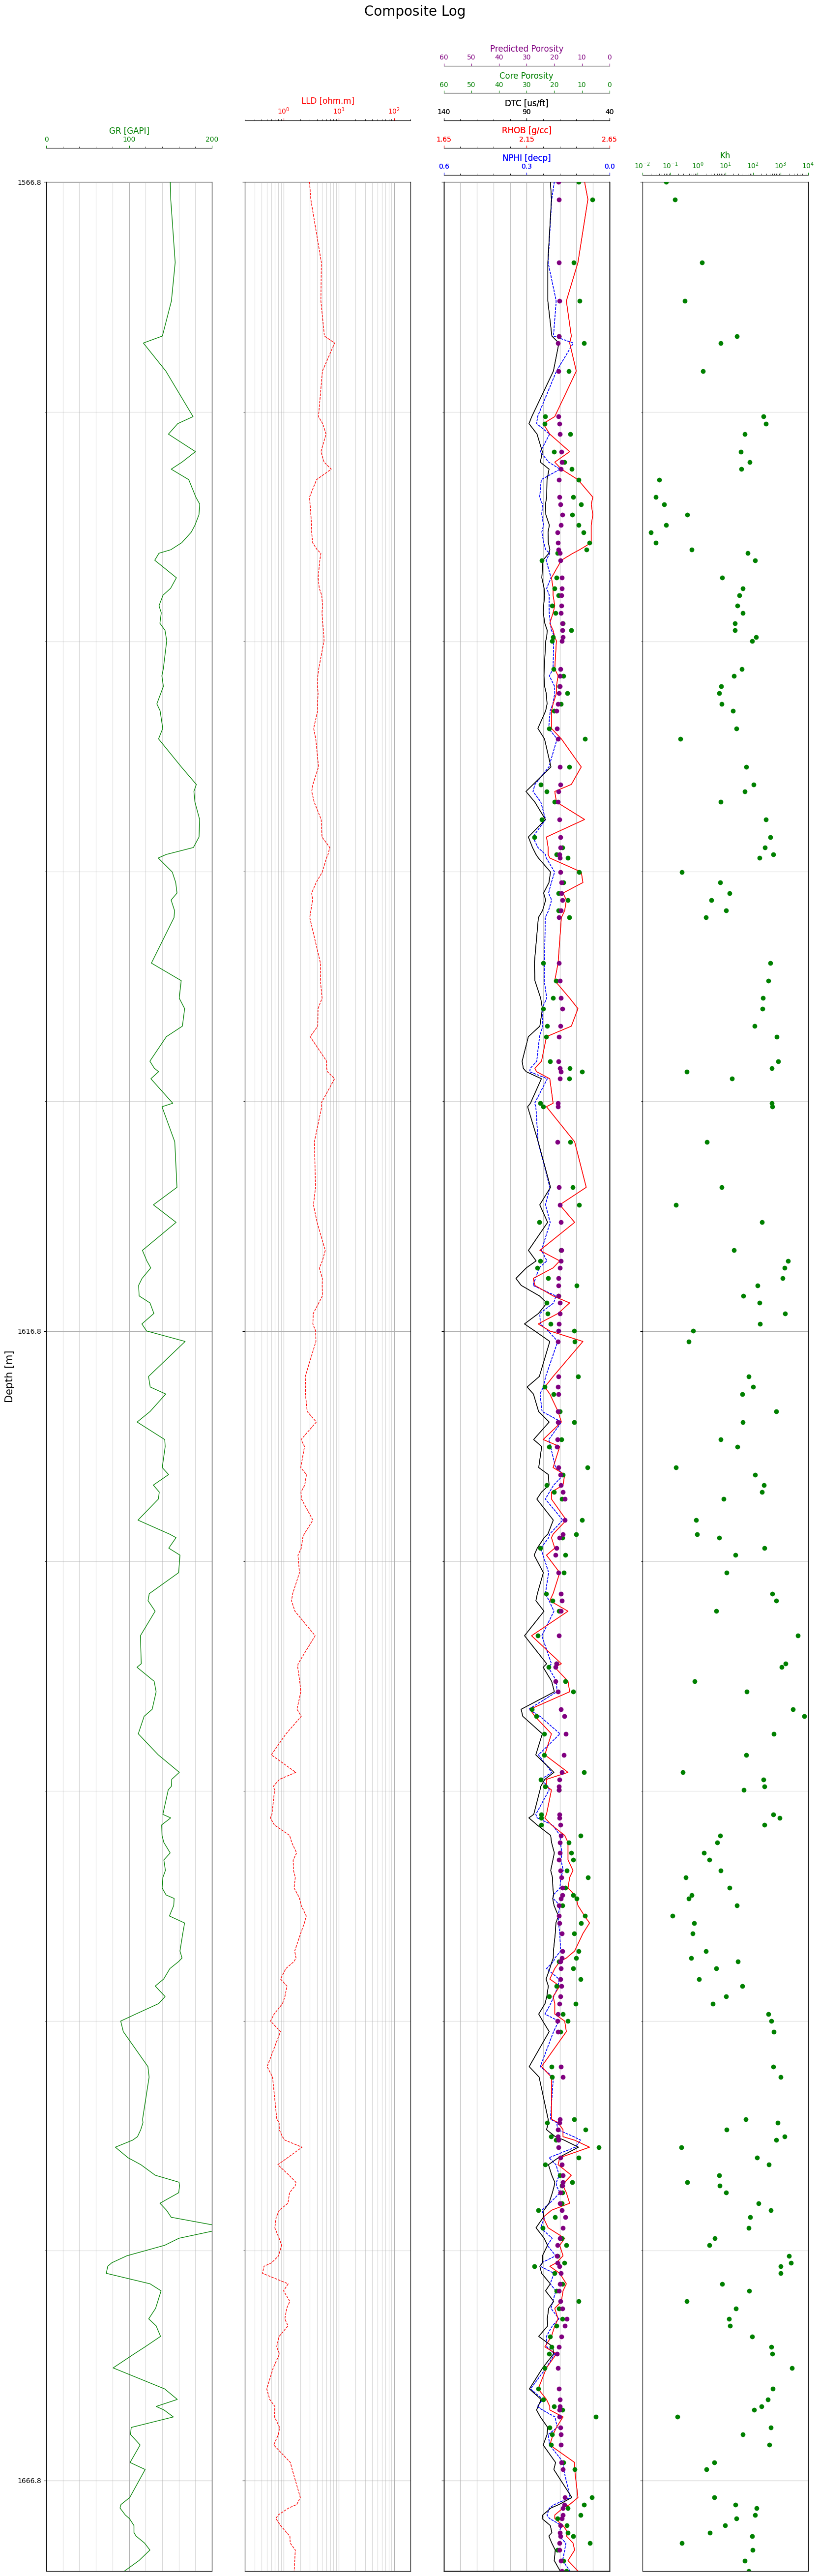

In [38]:
def plot_rcal(df,y_pred,depth_pred):
    '''
    Plot facies identified by geologist compared with clustering results
    '''
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,60),sharey=True)
    fig.suptitle("Composite Log", fontsize=20)
    fig.subplots_adjust(top=0.92)

    top = df['DEPTH'].min()
    bottom = df['DEPTH'].max()

    for axes in ax:
        axes.set_ylim(bottom,top)
        depth_major_ticks = np.arange(top, bottom, 50)
        depth_minor_ticks = np.arange(top, bottom, 10)
        axes.set_yticks(depth_major_ticks)
        axes.set_yticks(depth_minor_ticks, minor=True)
        axes.get_xaxis().set_visible(False)
        axes.grid(which='minor', axis='y', alpha=0.5)
        axes.grid(which='major', axis='y', alpha=1)


    ax[0].set_ylabel("Depth [m]",color="Black",fontsize=15)

    #Track 1: GR and CALI
    #GR
    ax_GR=ax[0].twiny()
    ax_GR.set_xlim(0,200)
    ax_GR.set_xlabel('GR [GAPI]',color="Green",fontsize=12)
    ax_GR.plot(df['GR'],df['DEPTH'],color="Green",label='GR [GAPI]',linewidth=1)
    ax_GR.tick_params(axis='x', colors='Green')
    ax_GR.spines['top'].set_position(('outward',50))
    major_ticks = np.arange(0, 201, 100)
    minor_ticks = np.arange(0, 201, 20)
    ax_GR.set_xticks(major_ticks)
    ax_GR.set_xticks(minor_ticks, minor=True)
    ax_GR.grid(which='minor', alpha=0.5)
    ax_GR.grid(which='major', alpha=1)


    #Track 2: Resistivity
    #LLD
    ax_LLD=ax[1].twiny()
    ax_LLD.set_xscale('log')
    ax_LLD.set_xlim(0.2,200)
    ax_LLD.set_xlabel('LLD [ohm.m]',color="Red",fontsize=12)
    ax_LLD.plot(df['LLD'],df['DEPTH'],'--',color="Red",label='LLD [ohm.m]',linewidth=1)
    ax_LLD.tick_params(axis='x', colors='Red')
    ax_LLD.spines['top'].set_position(('outward',90))
    ax_LLD.grid(which='minor', alpha=0.5)
    ax_LLD.grid(which='major', alpha=1)

#     #MSFL
#     ax_MSFL=ax[1].twiny()
#     ax_MSFL.set_xscale('log')
#     ax_MSFL.set_xlim(0.2,200)
#     ax_MSFL.set_xlabel('MSFL [ohm.m]',color="Black",fontsize=12)
#     ax_MSFL.plot(df['MSFL'],df['DEPTH'],color="Black",label='MSFL [ohm.m]',linewidth=1)
#     ax_MSFL.spines['top'].set_position(('outward',10))

      #Track 3: NPHI, RHOB, DTC, PET
    #NPHI
    ax_NEU=ax[2].twiny()
    ax_NEU.set_xlim(0.6,0)
    ax_NEU.set_xlabel('NPHI [decp]',color="Blue",fontsize=12)
    ax_NEU.plot(df['NPHI'],df['DEPTH'],'--',color="Blue",label='NPHI [decp]',linewidth=1)
    ax_NEU.tick_params(axis='x', colors='Blue')
    ax_NEU.spines['top'].set_position(('outward',10))
    major_ticks = np.arange(0, 0.61, 0.3)
    minor_ticks = np.arange(0, 0.61, 0.06)
    ax_NEU.set_xticks(major_ticks)
    ax_NEU.set_xticks(minor_ticks, minor=True)
    ax_NEU.grid(which='minor', alpha=0.5)
    ax_NEU.grid(which='major', alpha=1)

    #RHOB
    ax_RHOB=ax[2].twiny()
    ax_RHOB.set_xlim(1.65,2.65)
    ax_RHOB.set_xlabel('RHOB [g/cc]',color="Red",fontsize=12)
    ax_RHOB.plot(df['RHOB'],df['DEPTH'],color="Red",label='RHOB [g/cc]',linewidth=1)
    ax_RHOB.tick_params(axis='x', colors='Red')
    ax_RHOB.spines['top'].set_position(('outward',50))
    major_ticks = np.arange(1.65, 2.66, 0.5)
    minor_ticks = np.arange(1.65, 2.66, 0.1)
    ax_RHOB.set_xticks(major_ticks)
    ax_RHOB.set_xticks(minor_ticks, minor=True)

    #DTC
    ax_DTC=ax[2].twiny()
    ax_DTC.set_xlim(140,40)
    ax_DTC.set_xlabel('DTC [us/ft]',color="Black",fontsize=12)
    ax_DTC.plot(df['DTC'],df['DEPTH'],color="Black",label='DTC [us/ft]',linewidth=1)
    ax_DTC.spines['top'].set_position(('outward',90))
    major_ticks = np.arange(40, 141, 50)
    minor_ticks = np.arange(40, 141, 10)
    ax_DTC.set_xticks(major_ticks)
    ax_DTC.set_xticks(minor_ticks, minor=True)
#Track 3: NPHI, RHOB, DTC, PET
    #NPHI
    ax_NEU=ax[2].twiny()
    ax_NEU.set_xlim(0.6,0)
    ax_NEU.set_xlabel('NPHI [decp]',color="Blue",fontsize=12)
    ax_NEU.plot(df['NPHI'],df['DEPTH'],'--',color="Blue",label='NPHI [decp]',linewidth=1)
    ax_NEU.tick_params(axis='x', colors='Blue')
    ax_NEU.spines['top'].set_position(('outward',10))
    major_ticks = np.arange(0, 0.61, 0.3)
    minor_ticks = np.arange(0, 0.61, 0.06)
    ax_NEU.set_xticks(major_ticks)
    ax_NEU.set_xticks(minor_ticks, minor=True)
    ax_NEU.grid(which='minor', alpha=0.5)
    ax_NEU.grid(which='major', alpha=1)

    #RHOB
    ax_RHOB=ax[2].twiny()
    ax_RHOB.set_xlim(1.65,2.65)
    ax_RHOB.set_xlabel('RHOB [g/cc]',color="Red",fontsize=12)
    ax_RHOB.plot(df['RHOB'],df['DEPTH'],color="Red",label='RHOB [g/cc]',linewidth=1)
    ax_RHOB.tick_params(axis='x', colors='Red')
    ax_RHOB.spines['top'].set_position(('outward',50))
    major_ticks = np.arange(1.65, 2.66, 0.5)
    minor_ticks = np.arange(1.65, 2.66, 0.1)
    ax_RHOB.set_xticks(major_ticks)
    ax_RHOB.set_xticks(minor_ticks, minor=True)

    #DTC
    ax_DTC=ax[2].twiny()
    ax_DTC.set_xlim(140,40)
    ax_DTC.set_xlabel('DTC [us/ft]',color="Black",fontsize=12)
    ax_DTC.plot(df['DTC'],df['DEPTH'],color="Black",label='DTC [us/ft]',linewidth=1)
    ax_DTC.spines['top'].set_position(('outward',90))
    major_ticks = np.arange(40, 141, 50)
    minor_ticks = np.arange(40, 141, 10)
    ax_DTC.set_xticks(major_ticks)
    ax_DTC.set_xticks(minor_ticks, minor=True)

    #core porosity
    ax_por=ax[2].twiny()
    ax_por.set_xlim(60,0)
    ax_por.set_xlabel('Core Porosity',color="Green",fontsize=12)
    ax_por.scatter(df['HE POR'],df['DEPTH'],color="Green",label='Core Porosity',linewidth=1)
    ax_por.tick_params(axis='x', colors='Green')
    ax_por.spines['top'].set_position(('outward',130))

    #prediction results
    ax_pred=ax[2].twiny()
    ax_pred.set_xlim(60,0)
    ax_pred.set_xlabel('Predicted Porosity',color="Purple",fontsize=12)
    ax_pred.scatter(y_pred[:,0], depth_pred, color="Purple", label='Predicted Porosity', linewidth=1)
    ax_pred.tick_params(axis='x', colors='Purple')
    ax_pred.spines['top'].set_position(('outward',170))

    #KH
    ax_kh=ax[3].twiny()
    ax_kh.set_xscale('log')
    ax_kh.set_xlim(0.01,10000)
    ax_kh.set_xlabel('Kh',color="Green",fontsize=12)
    ax_kh.scatter(df['KH'],df['DEPTH'],color="Green",label='Kh',linewidth=1)
    ax_kh.tick_params(axis='x', colors='Green')
    ax_kh.spines['top'].set_position(('outward',10))

    #KH predicted
    #ax_kh_pred=ax[3].twiny()
    #ax_kh_pred.set_xscale('log')
    #ax_kh_pred.set_xlim(0.01,10000)
    #ax_kh_pred.set_xlabel('Kh Predicted',color="Purple",fontsize=12)
    #ax_kh_pred.scatter(y_pred[:,1],depth_pred[151:],color="Purple",label='Kh Predicted',linewidth=1)
    #ax_kh_pred.tick_params(axis='x', colors='Purple')
    #ax_kh_pred.spines['top'].set_position(('outward',50))

plot_rcal(las_df_well_1_TC_core,y_pred,las_df_well_1_TC_core['DEPTH'])

#Part 3

##**Predict Porosity and Permeability of other wells in the same field**

In [39]:
#load LAS data

las_df_well_2 = load_LAS("/content/drive/MyDrive/well_2.las")
las_df_well_2

CALI  DRHO       DTC       GR     LLD     LLS     MSFL  NPHI  \
DEPTH                                                                     
798.6139    NaN   NaN  174.4710  109.049  2.4615  1.5533  140.492   NaN   
798.7663    NaN   NaN  172.9800  107.666  2.4923  1.5761  136.075   NaN   
798.9187    NaN   NaN  171.5640  107.890  2.5163  1.5896  136.409   NaN   
799.0711    NaN   NaN  169.0380  112.576  2.5545  1.6051  111.354   NaN   
799.2235    NaN   NaN  168.3960  115.341  2.5597  1.6026  115.442   NaN   
...         ...   ...       ...      ...     ...     ...      ...   ...   
2087.0035   NaN   NaN   80.5212      NaN     NaN     NaN      NaN   NaN   
2087.1559   NaN   NaN   80.5212      NaN     NaN     NaN      NaN   NaN   
2087.3083   NaN   NaN   80.5212      NaN     NaN     NaN      NaN   NaN   
2087.4607   NaN   NaN   80.5212      NaN     NaN     NaN      NaN   NaN   
2087.6131   NaN   NaN   80.5212      NaN     NaN     NaN      NaN   NaN   

             RHOB       SP      AZIM      EASTING      INC    NORTHING  \
DEPTH                                                                    
798.6139   2.0012 -327.163  125.2955  401253.4375  43.0868  85595.0938   
798.7663   2.0055 -326.795  125.2947  401253.5625  43.0877  85595.0078   
798.9187   2.0096 -326.736  125.2944  401253.6250  43.0882  85594.9688   
799.0711   2.0171 -326.973  125.2936  401253.7188  43.0891  85594.8906   
799.2235   2.0190 -327.003  125.2933  401253.7813  43.0896  85594.8516   
...           ...      ...       ...          ...      ...         ...   
2087.0035  2.6208      NaN  135.2137  401799.9063  24.6800  85082.6406   
2087.1559  2.6208      NaN  135.2137  401799.9688  24.6800  85082.5781   
2087.3083  2.6208      NaN  135.2137  401800.0000  24.6800  85082.5469   
2087.4607  2.6208      NaN  135.2137  401800.0625  24.6800  85082.4922   
2087.6131  2.6208      NaN  135.2137  401800.0938  24.6800  85082.4609   

                 TVD      DEPTH  
DEPTH                            
798.6139    736.4166   798.6139  
798.7663    736.5627   798.7663  
798.9187    736.6357   798.9187  
799.0711    736.7818   799.0711  
799.2235    736.8549   799.2235  
...              ...        ...  
2087.0035  1775.0187  2087.0035  
2087.1559  1775.2004  2087.1559  
2087.3083  1775.2913  2087.3083  
2087.4607  1775.4730  2087.4607  
2087.6131  1775.5640  2087.6131  

[8459 rows x 16 columns]

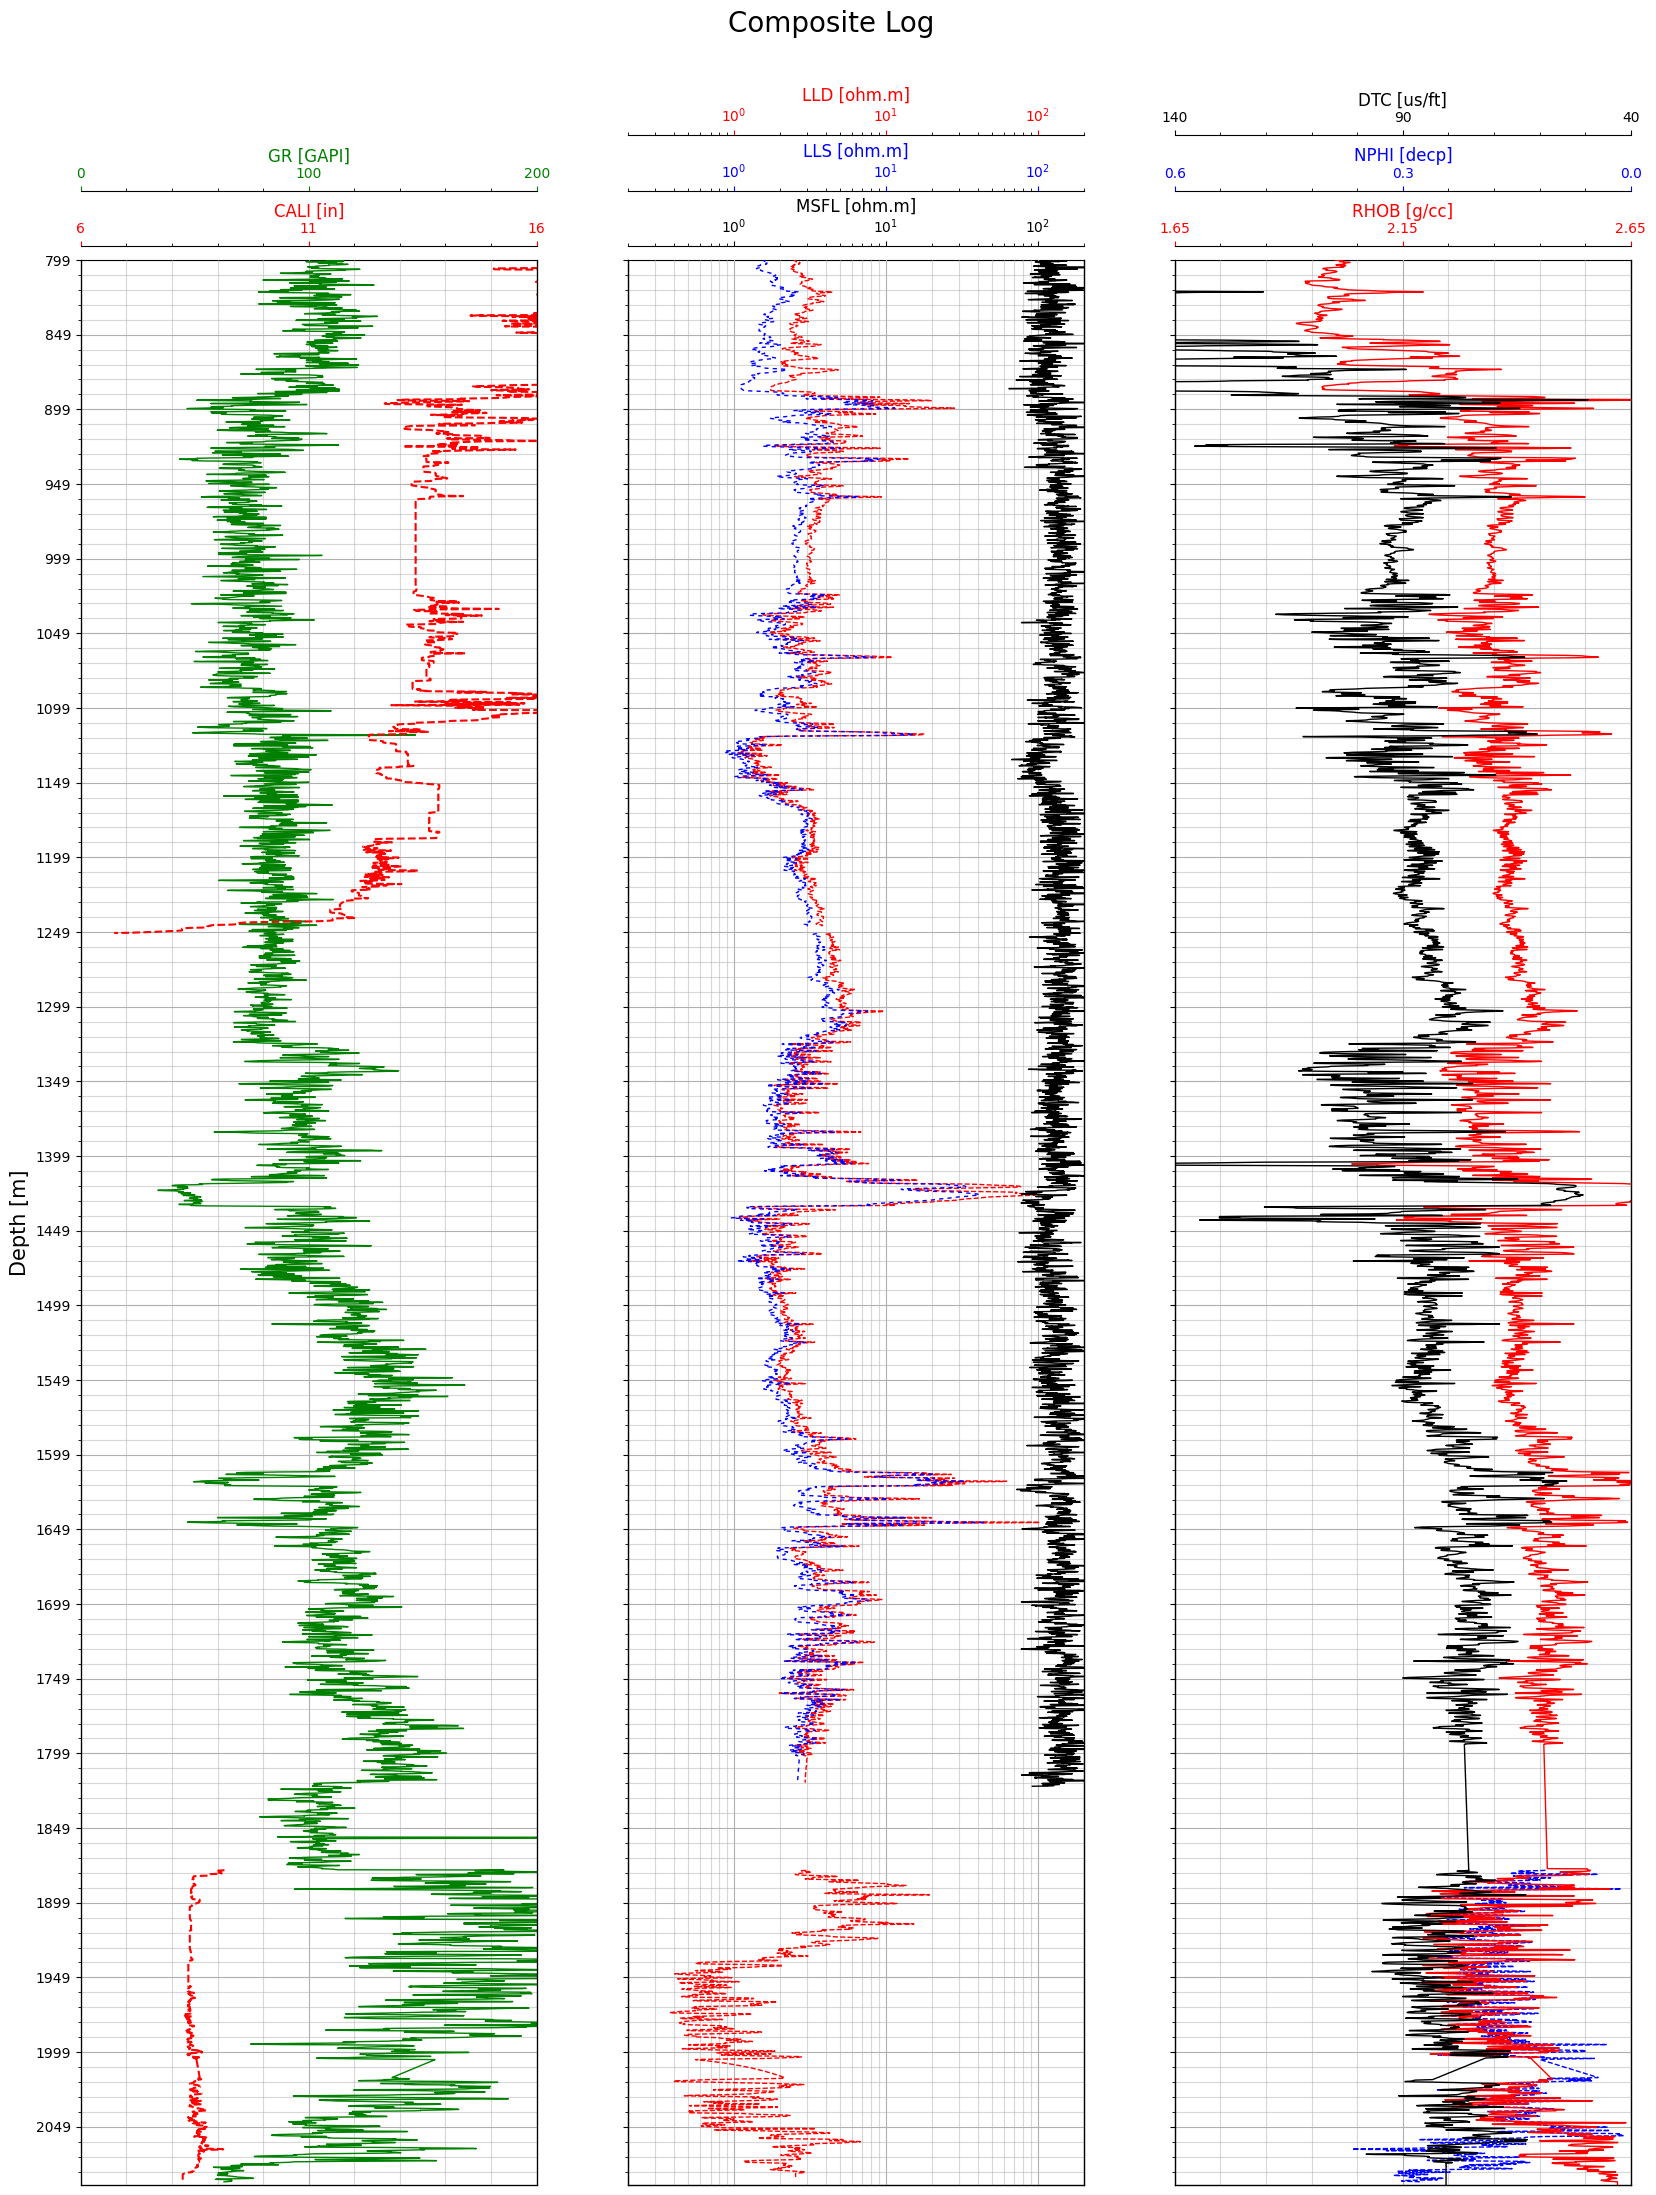

In [40]:
top = las_df_well_2['DEPTH'].min()
bottom = las_df_well_2['DEPTH'].max()

wireline_log_plotting(top,bottom,las_df_well_2)

In [45]:
las_df_well_2_TC = las_df_well_2[['DEPTH', 'GR', 'NPHI', 'RHOB', 'DTC', 'LLD']].copy()
las_df_well_2_TC.index = pd.RangeIndex(len(las_df_well_2_TC))
las_df_well_2_TC.head()

DEPTH       GR  NPHI    RHOB      DTC     LLD
0  798.6139  109.049   NaN  2.0012  174.471  2.4615
1  798.7663  107.666   NaN  2.0055  172.980  2.4923
2  798.9187  107.890   NaN  2.0096  171.564  2.5163
3  799.0711  112.576   NaN  2.0171  169.038  2.5545
4  799.2235  115.341   NaN  2.0190  168.396  2.5597

In [42]:
#load RCAL data

df_rcal_well_2 = pd.read_csv('/content/drive/MyDrive/well_2_rcal.csv')
df_rcal_well_2

DEPTH (m)  HE POR    KH     KV    Shift  1.1  Unnamed: 6
0       1885.02    13.8  1.40  20.00  1886.12  NaN         NaN
1       1885.25    14.4  5.90    NaN  1886.35  NaN         NaN
2       1885.50     9.3  0.14    NaN  1886.60  NaN         NaN
3       1885.76    12.5  0.18    NaN  1886.86  NaN         NaN
4       1886.02    12.4  0.37   0.03  1887.12  NaN         NaN
...         ...     ...   ...    ...      ...  ...         ...
3966        NaN     NaN   NaN    NaN      NaN  NaN         NaN
3967        NaN     NaN   NaN    NaN      NaN  NaN         NaN
3968        NaN     NaN   NaN    NaN      NaN  NaN         NaN
3969        NaN     NaN   NaN    NaN      NaN  NaN         NaN
3970        NaN     NaN   NaN    NaN      NaN  NaN         NaN

[3971 rows x 7 columns]

In [46]:
#create dataframe for scaled data
df_scaled_well_2 = scaling_features(las_df_well_2_TC)
df_scaled_well_2.head()

DEPTH        GR  NPHI      RHOB       DTC       LLD
0  798.6139  0.210526   NaN  0.102477  0.791153  0.020336
1  798.7663  0.206656   NaN  0.107674  0.781723  0.020637
2  798.9187  0.207283   NaN  0.112628  0.772769  0.020871
3  799.0711  0.220397   NaN  0.121692  0.756794  0.021244
4  799.2235  0.228135   NaN  0.123988  0.752734  0.021294

In [47]:
# Add core data to the dataframe
las_df_well_2_TC_core = shift_core_depth(
                                            las_df_well_2_TC,
                                            df_rcal_well_2,
                                            col_name='KH',
                                            depth_rcal='Shift',
                                            depth='DEPTH'
                                        )
las_df_well_2_TC_core.head()

<ipython-input-23-96004ca61c87>:21: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_in[col_name].iloc[i] = df_rcal[col_name][df_rcal[depth_rcal]==core_depth].values[0]
<ipython-input-23-96004ca61c87>:21: FutureWarning: ChainedAssignmentErro

DEPTH       GR  NPHI    RHOB      DTC     LLD  KH
0  798.6139  109.049   NaN  2.0012  174.471  2.4615 NaN
1  798.7663  107.666   NaN  2.0055  172.980  2.4923 NaN
2  798.9187  107.890   NaN  2.0096  171.564  2.5163 NaN
3  799.0711  112.576   NaN  2.0171  169.038  2.5545 NaN
4  799.2235  115.341   NaN  2.0190  168.396  2.5597 NaN

In [48]:
# Add core data to the dataframe
las_df_well_2_TC_core = shift_core_depth(
                                            las_df_well_2_TC_core,
                                            df_rcal_well_2,
                                            col_name='HE POR',
                                            depth_rcal='Shift',
                                            depth='DEPTH'
                                        )
las_df_well_2_TC_core.head()

<ipython-input-23-96004ca61c87>:21: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_in[col_name].iloc[i] = df_rcal[col_name][df_rcal[depth_rcal]==core_depth].values[0]
<ipython-input-23-96004ca61c87>:21: FutureWarning: ChainedAssignmentErro

DEPTH       GR  NPHI    RHOB      DTC     LLD  KH  HE POR
0  798.6139  109.049   NaN  2.0012  174.471  2.4615 NaN     NaN
1  798.7663  107.666   NaN  2.0055  172.980  2.4923 NaN     NaN
2  798.9187  107.890   NaN  2.0096  171.564  2.5163 NaN     NaN
3  799.0711  112.576   NaN  2.0171  169.038  2.5545 NaN     NaN
4  799.2235  115.341   NaN  2.0190  168.396  2.5597 NaN     NaN

In [49]:
las_df_well_2_TC_core = las_df_well_2_TC_core.loc[las_df_well_2_TC_core['DEPTH']>1880].dropna()
las_df_well_2_TC_core.index = pd.RangeIndex(len(las_df_well_2_TC_core.index))
las_df_well_2_TC_core.head()

DEPTH       GR    NPHI    RHOB      DTC      LLD     KH  HE POR
0  1886.1403  177.375  0.1580  2.4193  75.8117  10.2281   1.40    13.8
1  1886.4451  162.800  0.1539  2.4679  79.0125  10.4848   5.90    14.4
2  1886.9023  167.644  0.1606  2.5263  79.0704  12.5748   0.18    12.5
3  1887.2071  166.093  0.1480  2.5153  77.5949  13.5280   0.37    12.4
4  1887.3595  155.248  0.1067  2.5177  77.6811  12.1009  49.00    11.5

In [50]:
#save the dataframe
las_df_well_2_TC_core.to_csv('las_df_well_2_TC_core.csv')

In [51]:
test_X_df_2 = las_df_well_2_TC_core.drop(['DEPTH','HE POR','KH'],axis=1)
test_X_df_2

GR    NPHI    RHOB      DTC      LLD
0    177.375  0.1580  2.4193  75.8117  10.2281
1    162.800  0.1539  2.4679  79.0125  10.4848
2    167.644  0.1606  2.5263  79.0704  12.5748
3    166.093  0.1480  2.5153  77.5949  13.5280
4    155.248  0.1067  2.5177  77.6811  12.1009
..       ...     ...     ...      ...      ...
151  185.863  0.1739  2.3257  85.8084   0.6958
152  168.891  0.1651  2.3066  74.6443   0.9145
153  167.699  0.2224  2.2167  89.1595   0.4355
154  211.222  0.2050  2.2800  85.7968   0.5714
155  193.481  0.1994  2.2602  80.1433   0.8723

[156 rows x 5 columns]

In [52]:
scaler = MinMaxScaler()
df_temp = las_df_well_2_TC_core
df_scaled_well_2 = pd.DataFrame(scaler.fit_transform(las_df_well_2_TC_core), columns=las_df_well_2_TC_core.columns)
df_scaled_well_2['DEPTH'] = df_temp['DEPTH']
df_scaled_well_2['HE POR'] = df_temp['HE POR']
df_scaled_well_2['KH'] = df_temp['KH']
df_scaled_well_2

DEPTH        GR      NPHI      RHOB       DTC       LLD      KH  \
0    1886.1403  0.407028  0.556996  0.613057  0.347405  0.538946    1.40   
1    1886.4451  0.310425  0.538668  0.742038  0.446950  0.553032    5.90   
2    1886.9023  0.342531  0.568619  0.897028  0.448750  0.667724    0.18   
3    1887.2071  0.332251  0.512293  0.867834  0.402862  0.720032    0.37   
4    1887.3595  0.260370  0.327671  0.874204  0.405543  0.641718   49.00   
..         ...       ...       ...       ...       ...       ...     ...   
151  1950.9103  0.463287  0.628073  0.364650  0.658302  0.015848  153.00   
152  1951.6723  0.350796  0.588735  0.313960  0.311099  0.027850    1.20   
153  1952.1295  0.342895  0.844882  0.075372  0.762521  0.001564    1.40   
154  1953.1963  0.631368  0.767099  0.243365  0.657941  0.009022  116.00   
155  1953.6535  0.513780  0.742065  0.190817  0.482118  0.025534  189.00   

     HE POR  
0      13.8  
1      14.4  
2      12.5  
3      12.4  
4      11.5  
..      ...  
151    18.2  
152    16.6  
153    13.4  
154    18.2  
155    10.6  

[156 rows x 8 columns]

In [53]:
test_X_df_2 = df_scaled_well_2.drop(['DEPTH','HE POR','KH'],axis=1)
test_X_df_2

GR      NPHI      RHOB       DTC       LLD
0    0.407028  0.556996  0.613057  0.347405  0.538946
1    0.310425  0.538668  0.742038  0.446950  0.553032
2    0.342531  0.568619  0.897028  0.448750  0.667724
3    0.332251  0.512293  0.867834  0.402862  0.720032
4    0.260370  0.327671  0.874204  0.405543  0.641718
..        ...       ...       ...       ...       ...
151  0.463287  0.628073  0.364650  0.658302  0.015848
152  0.350796  0.588735  0.313960  0.311099  0.027850
153  0.342895  0.844882  0.075372  0.762521  0.001564
154  0.631368  0.767099  0.243365  0.657941  0.009022
155  0.513780  0.742065  0.190817  0.482118  0.025534

[156 rows x 5 columns]

In [54]:
# test_y_df_2 = las_df_well_2_TC_core[['HE POR','KH']]
test_y_df_2 = las_df_well_2_TC_core[['HE POR']]

In [55]:
test_y_df_2 = df_scaled_well_2[['HE POR']]
test_y_df_2

HE POR
0      13.8
1      14.4
2      12.5
3      12.4
4      11.5
..      ...
151    18.2
152    16.6
153    13.4
154    18.2
155    10.6

[156 rows x 1 columns]